In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml
import math
import h5py
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from eventsFactory import getEvents
from reco import getRecoResults

In [2]:
RUN         = 1231

DATA_PATH   = "../data/"
DATA_FILE   = DATA_PATH + f"RUN00{RUN}_data.txt"

CONFIG_PATH = "../config/"
CONFIG_FILE = CONFIG_PATH + f"RUN00{RUN}.yml"

In [3]:
stream_df = pd.read_csv(DATA_FILE)
stream_df.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,2,1,129,52697671.0,1273.0,6.0
1,2,1,129,52697681.0,1290.0,22.0
2,2,1,129,52697685.0,1530.0,21.0
3,2,1,129,52697686.0,1959.0,7.0
4,2,1,129,52697693.0,2154.0,12.0
5,2,1,129,52697695.0,17.0,1.0
6,2,1,129,52697695.0,892.0,22.0
7,2,1,129,52697696.0,646.0,11.0
8,2,0,11,52697698.0,1586.0,27.0
9,2,0,11,52697698.0,1598.0,25.0


In [4]:
with open(CONFIG_FILE, "r") as config_file:
    cfg = yaml.safe_load(config_file)

In [5]:
useTrigger = False # what does this parameter do??
runTimeShift = 0   # what does this parameter do??

keep = ["FPGA", "TDC_CHANNEL", "HIT_DRIFT_TIME", "m"]

In [6]:
df = pd.DataFrame()
# reco
events = getEvents(stream_df, cfg, runTimeShift, useTrigger)
resultsList, resultsData, resultsHits, resultsDf = getRecoResults(events, useTrigger)
# out df
for df_ in resultsDf:   
    df_ = df_[keep]
    df = pd.concat([df, df_], axis=0, ignore_index=True)

84056534


/Users/niklai/miniforge3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [7]:
df.loc[(df["FPGA"]==0), "CH"] = df["TDC_CHANNEL"]
df.loc[(df["FPGA"]==1), "CH"] = df["TDC_CHANNEL"]+128
df_ = df.drop(["FPGA", "TDC_CHANNEL"], axis=1)
df_["CH"]=df_["CH"].astype(np.uint32)

df = df_[["CH", "HIT_DRIFT_TIME", "m"]]
df = df[(df["HIT_DRIFT_TIME"]>-200) & (df["HIT_DRIFT_TIME"]<600)]
df["THETA"] = np.arctan(df["m"])*180./math.pi

df.head(10)

,CH,HIT_DRIFT_TIME,m,THETA
0,103,193.833333,0.117564,6.705149
1,102,253.833333,0.117564,6.705149
2,104,116.333333,0.117564,6.705149
3,105,180.500000,0.117564,6.705149
4,172,61.033333,0.177071,10.041339
5,171,327.700000,0.177071,10.041339
6,173,40.200000,0.177071,10.041339
7,174,372.700000,0.177071,10.041339
8,229,50.333333,0.231331,13.025192
9,228,143.666667,0.231331,13.025192


In [13]:
wires = []

for wire in np.unique(df["CH"]):
    wires.append(df[df["CH"]==wire])
    df[df["CH"]==wire].to_hdf('../data/test_ch.h5', key=f'ch{wire}', mode='a')

In [14]:
f = h5py.File('../data/test_ch.h5', 'r')
f.keys()

<KeysViewHDF5 ['ch100', 'ch101', 'ch102', 'ch103', 'ch104', 'ch105', 'ch106', 'ch107', 'ch108', 'ch109', 'ch110', 'ch111', 'ch112', 'ch113', 'ch114', 'ch115', 'ch116', 'ch117', 'ch118', 'ch119', 'ch120', 'ch121', 'ch122', 'ch123', 'ch124', 'ch125', 'ch126', 'ch127', 'ch128', 'ch129', 'ch130', 'ch131', 'ch132', 'ch133', 'ch134', 'ch135', 'ch136', 'ch137', 'ch138', 'ch139', 'ch140', 'ch144', 'ch145', 'ch146', 'ch147', 'ch148', 'ch149', 'ch150', 'ch151', 'ch152', 'ch153', 'ch154', 'ch155', 'ch156', 'ch157', 'ch158', 'ch159', 'ch160', 'ch161', 'ch162', 'ch163', 'ch164', 'ch165', 'ch166', 'ch167', 'ch168', 'ch169', 'ch170', 'ch171', 'ch172', 'ch173', 'ch174', 'ch175', 'ch176', 'ch177', 'ch178', 'ch179', 'ch180', 'ch181', 'ch182', 'ch183', 'ch184', 'ch185', 'ch186', 'ch188', 'ch189', 'ch190', 'ch191', 'ch192', 'ch193', 'ch194', 'ch195', 'ch196', 'ch197', 'ch198', 'ch199', 'ch200', 'ch201', 'ch202', 'ch203', 'ch204', 'ch205', 'ch206', 'ch207', 'ch208', 'ch209', 'ch210', 'ch211', 'ch212', 'ch2

In [15]:
full_df = pd.concat(
    [
        pd.read_hdf('../data/test_ch.h5', key=k, mode="r") for k in f.keys()
    ],
    ignore_index=True
)

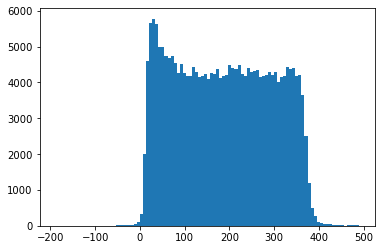

In [26]:
plt.hist(
    full_df["HIT_DRIFT_TIME"],
    bins=100,
    range=(-190, 490)
)
plt.show()

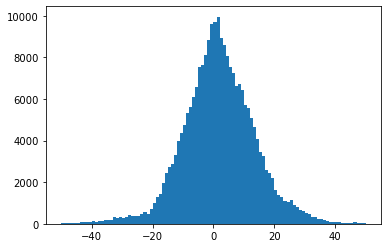

In [29]:
plt.hist(
    full_df["THETA"],
    bins=100,
    range=(-50, 50)
)
plt.show()

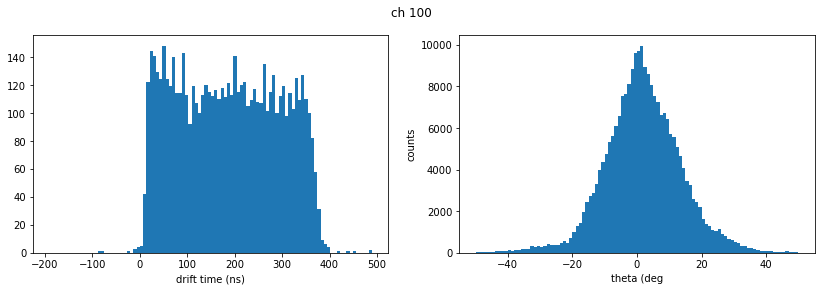

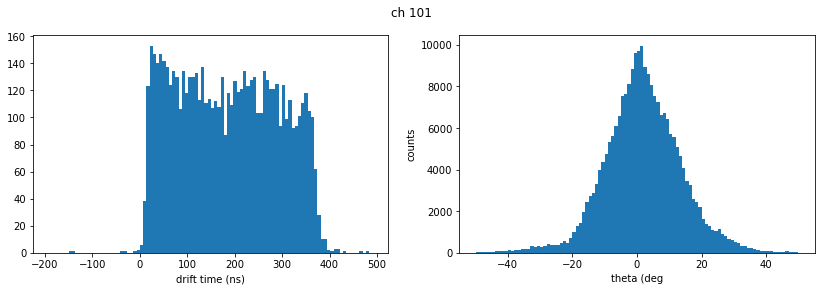

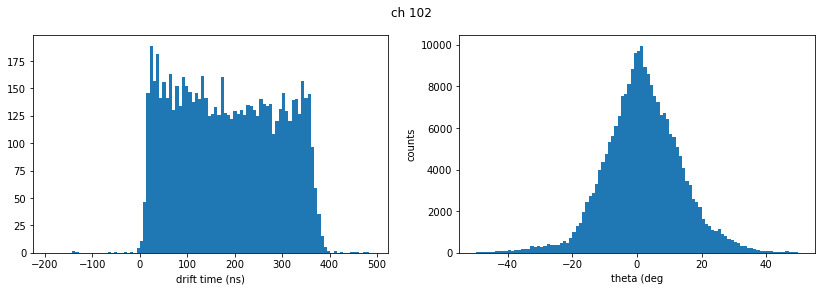

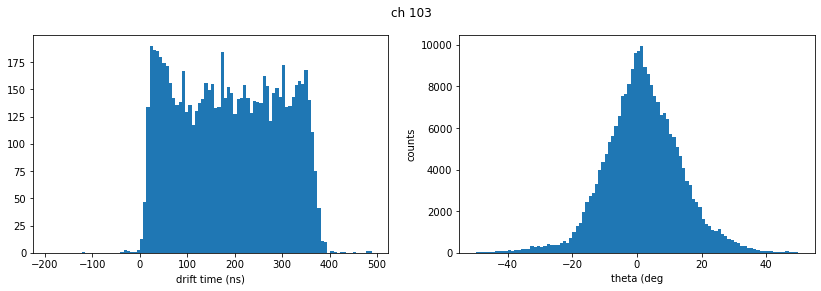

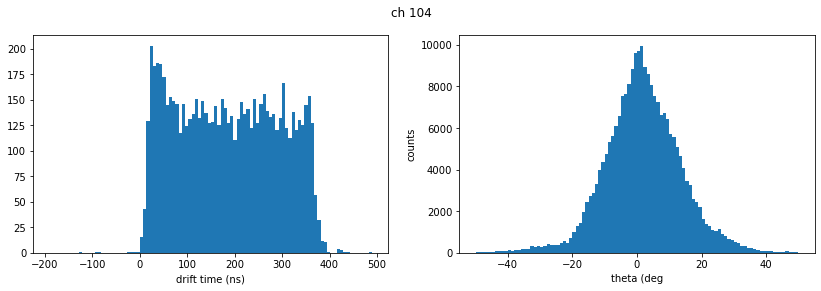

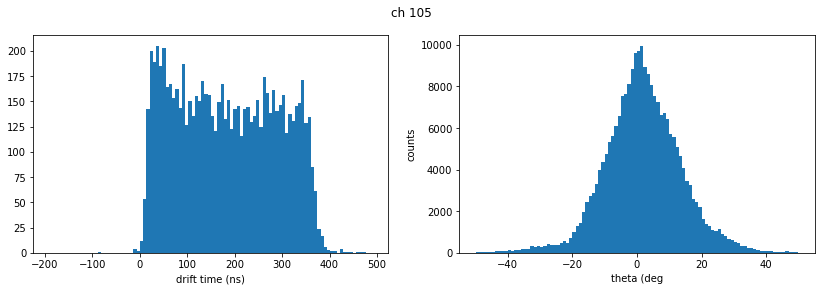

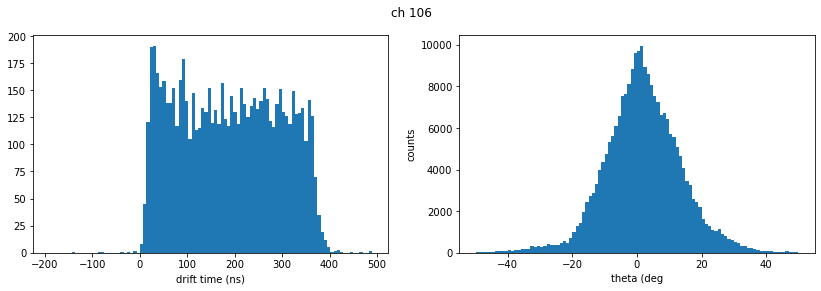

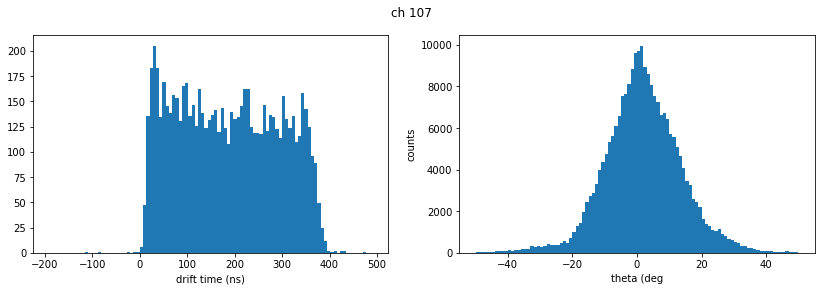

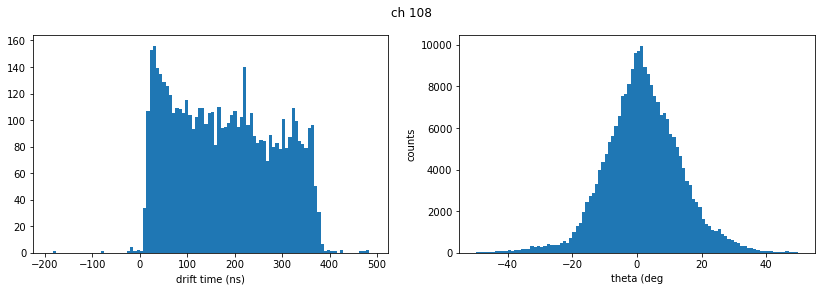

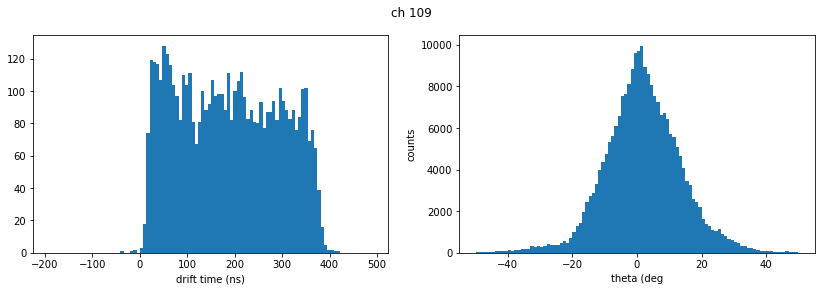

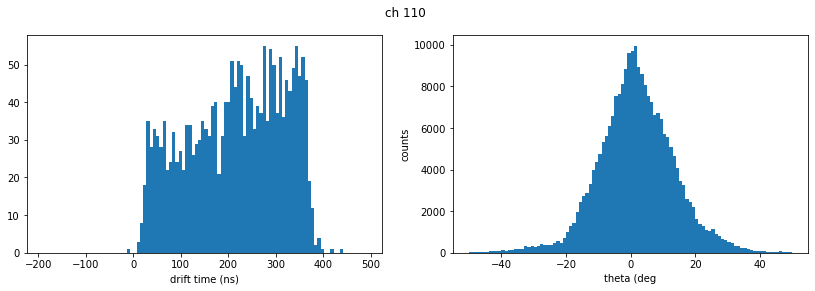

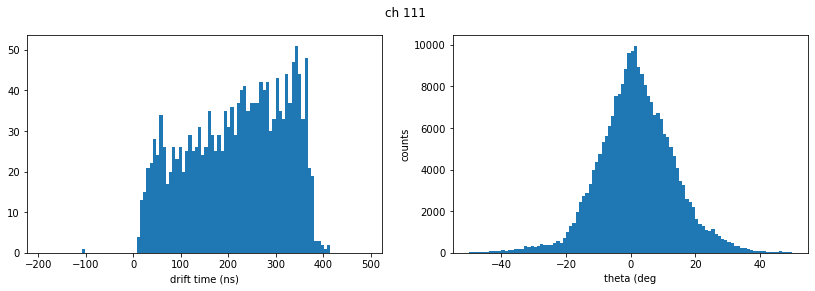

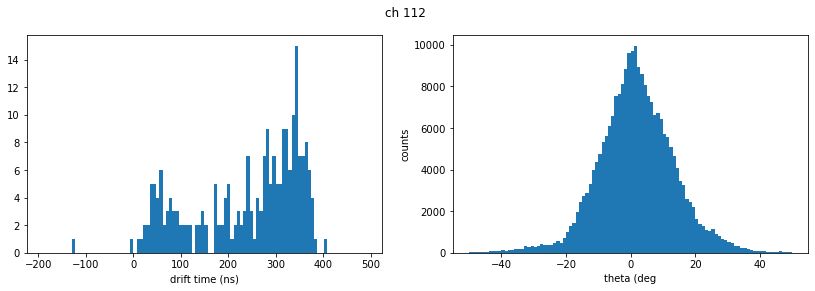

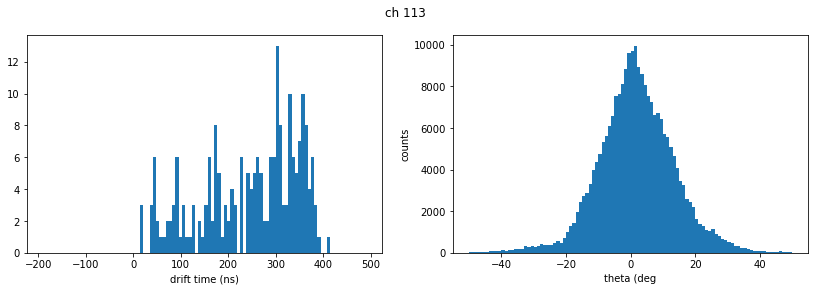

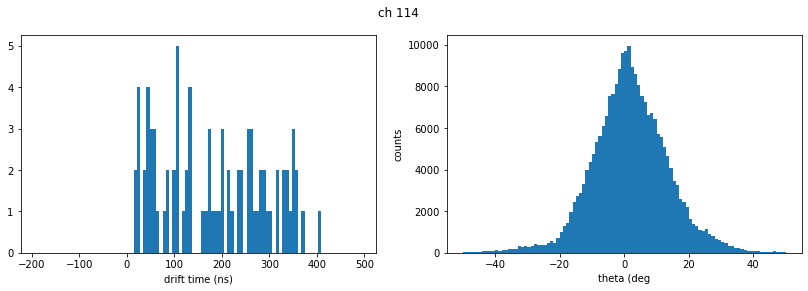

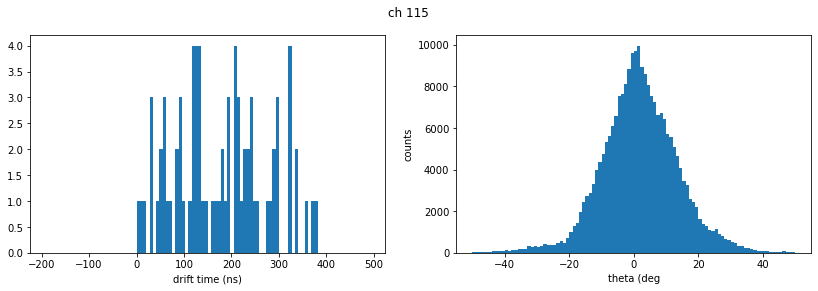

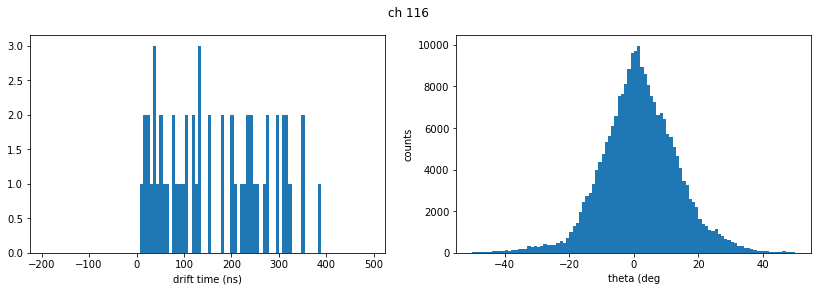

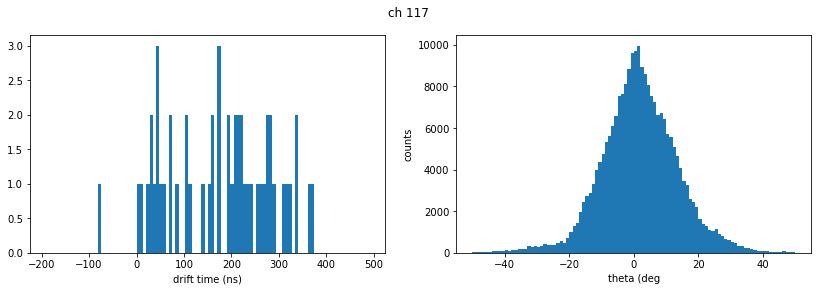

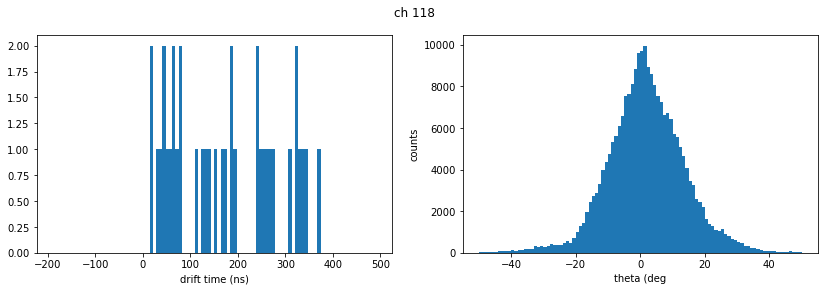

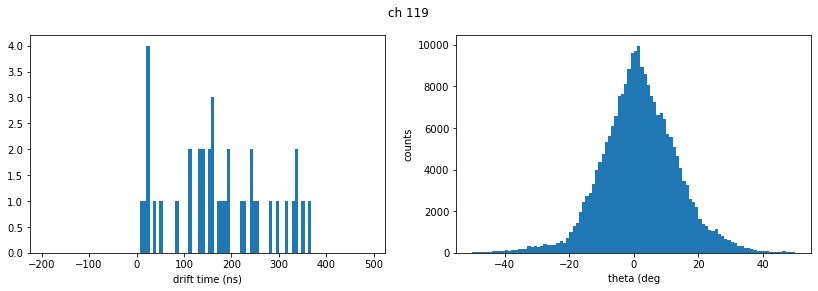

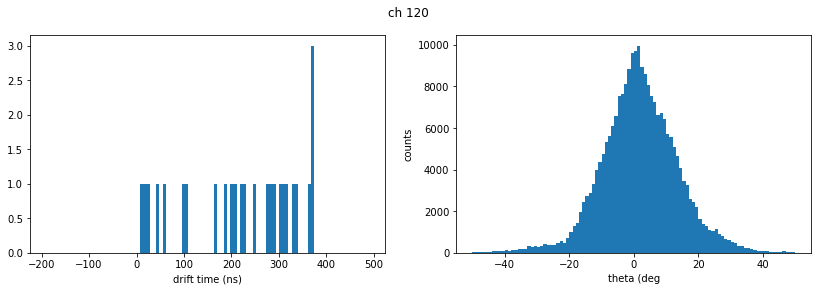

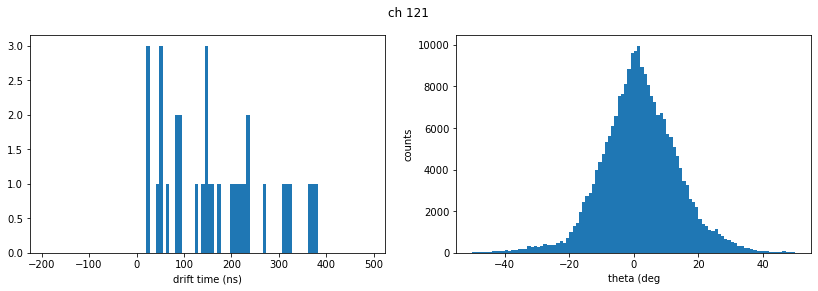

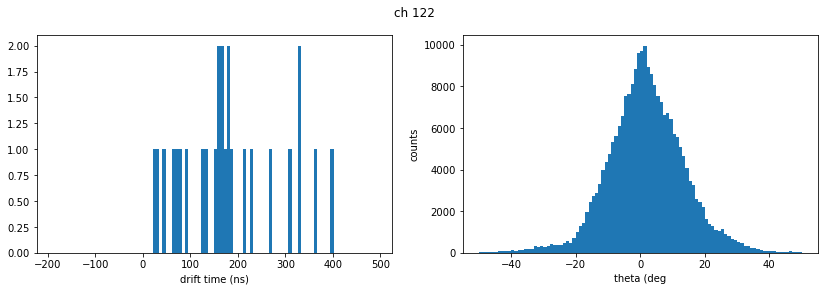

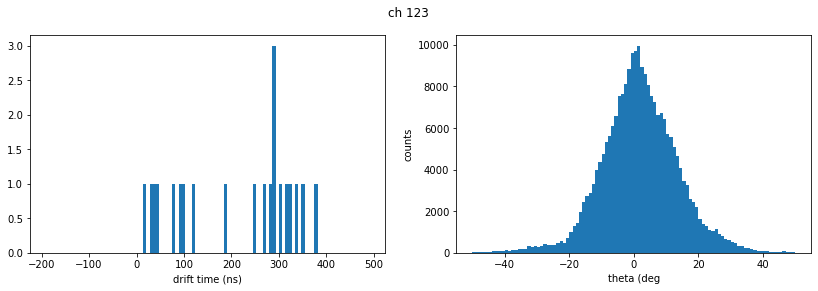

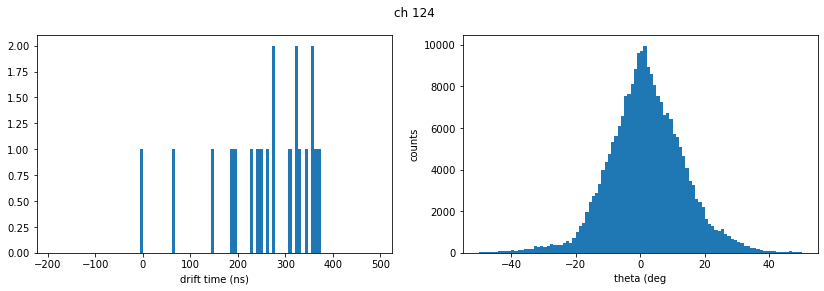

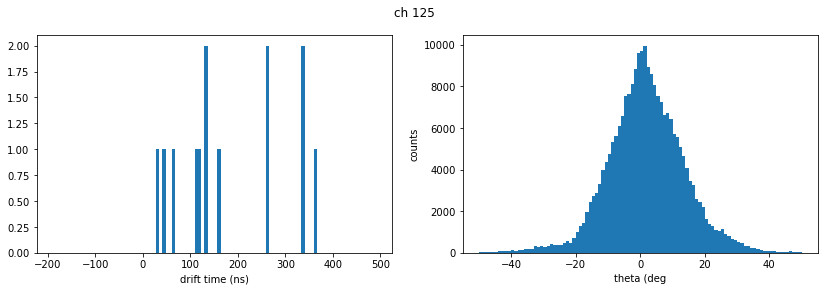

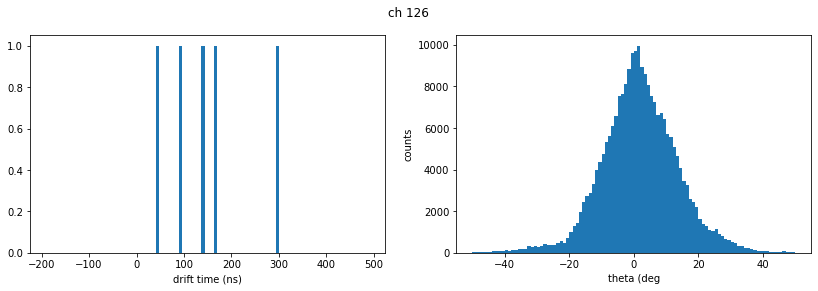

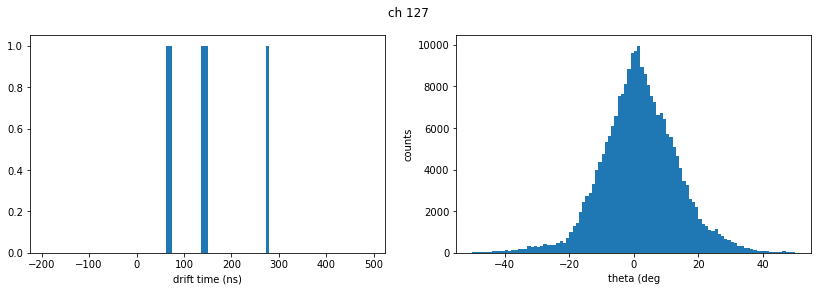

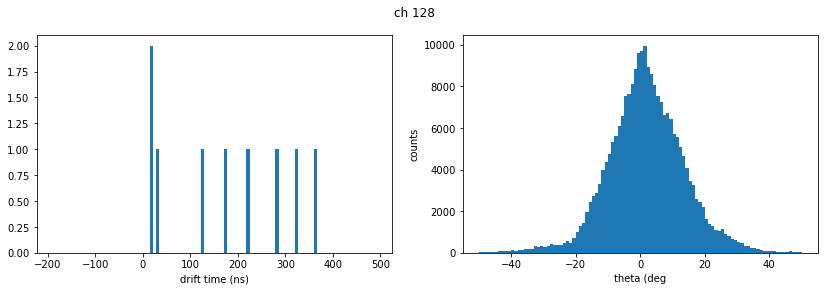

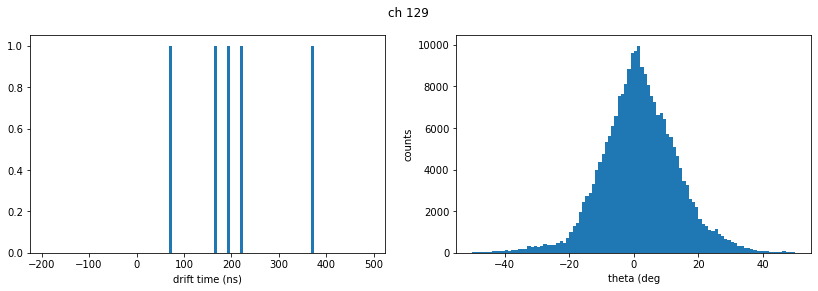

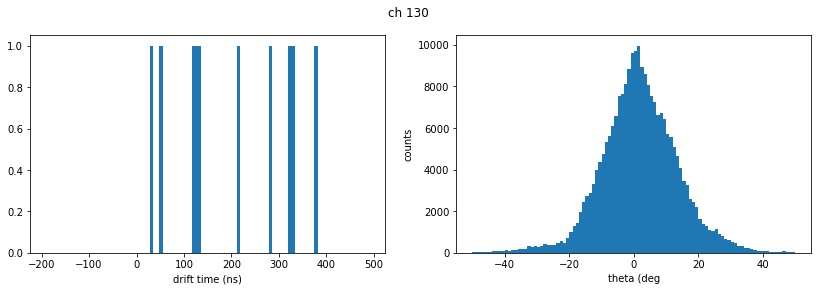

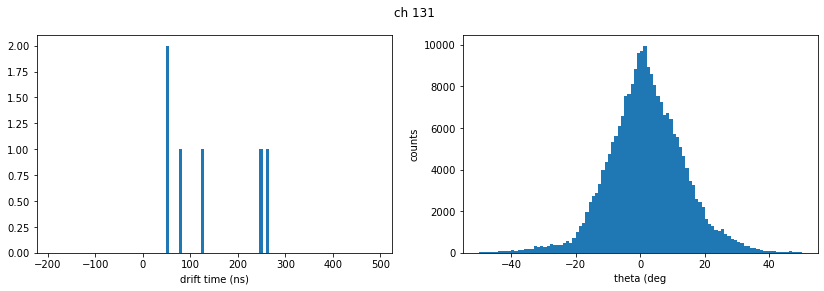

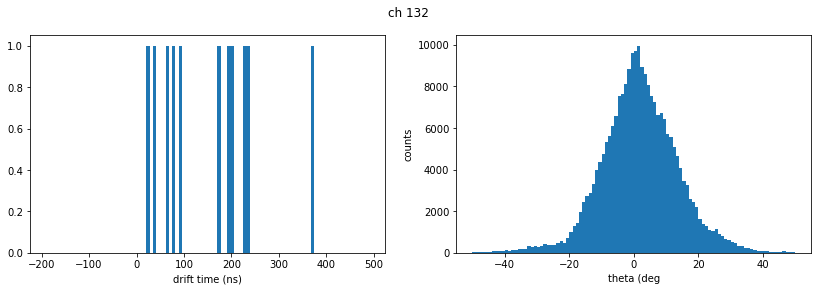

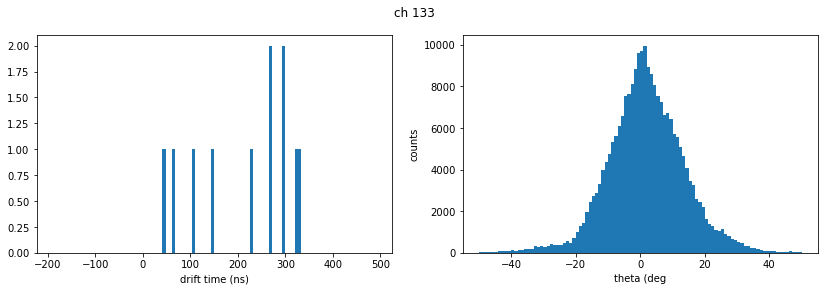

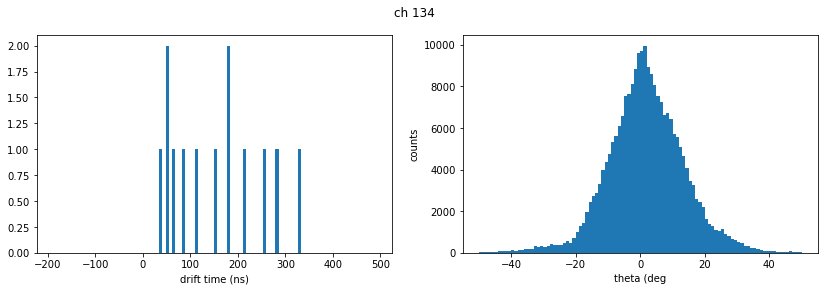

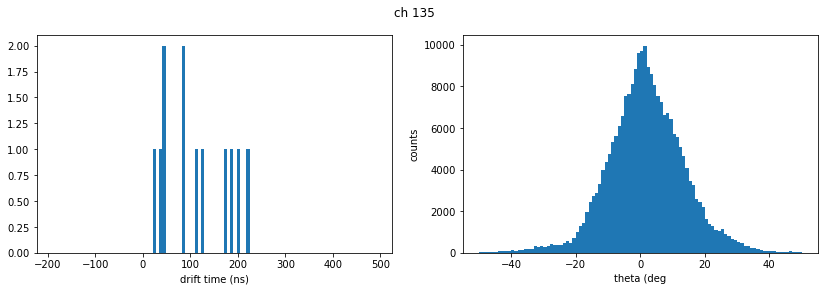

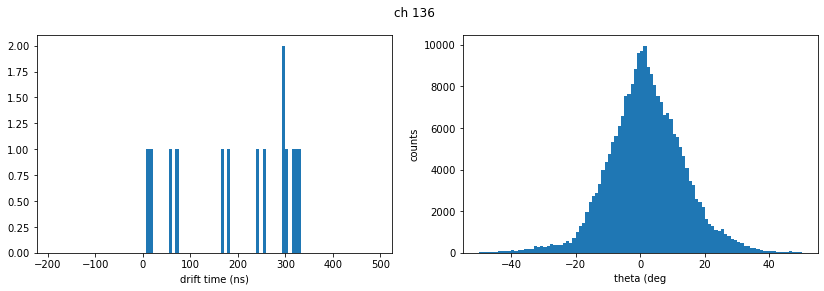

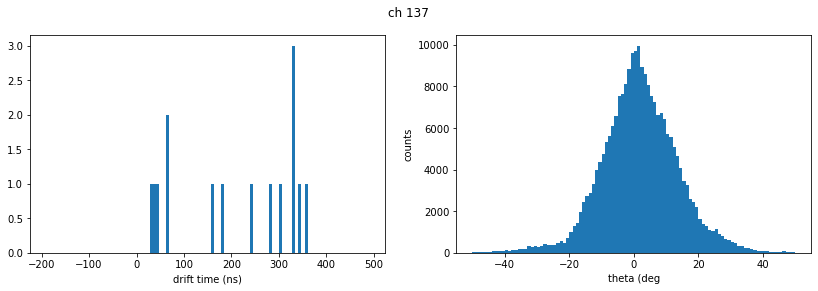

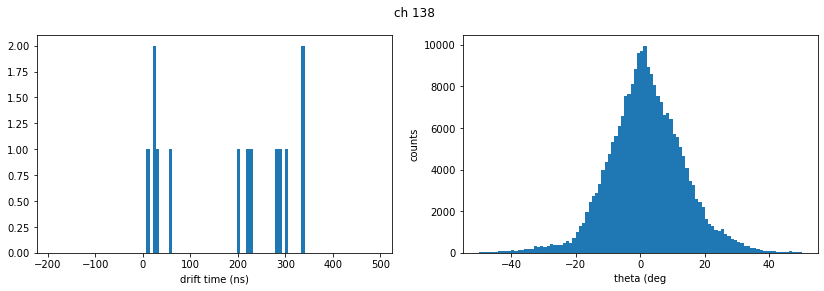

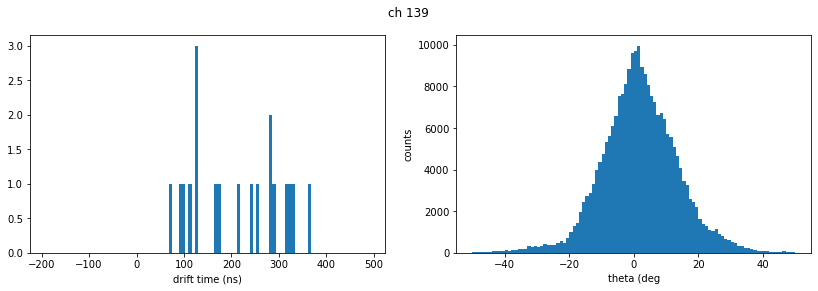

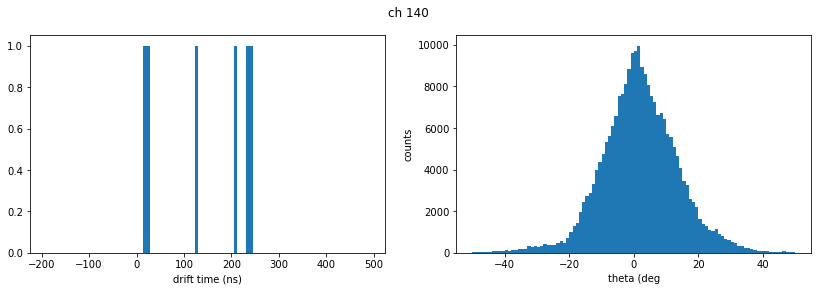

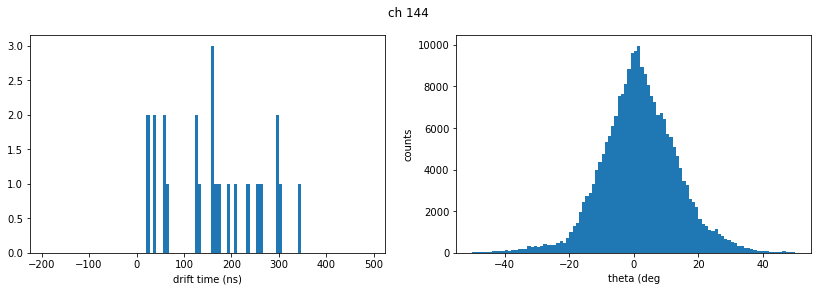

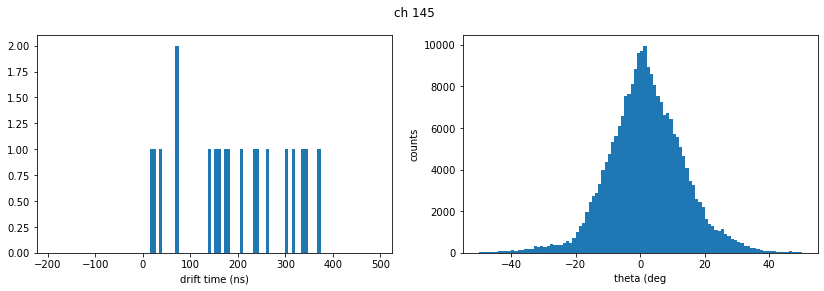

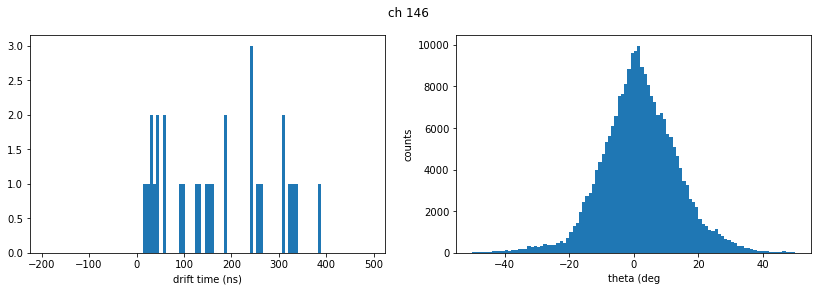

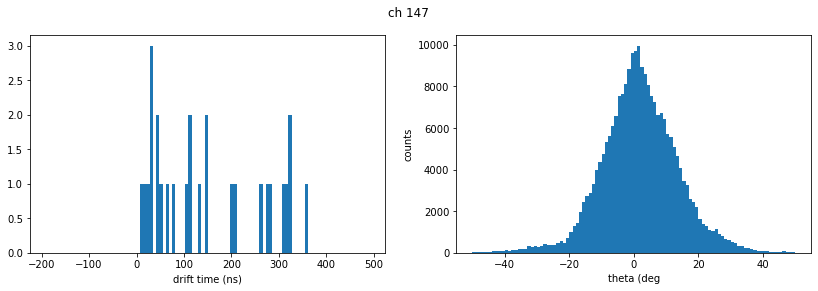

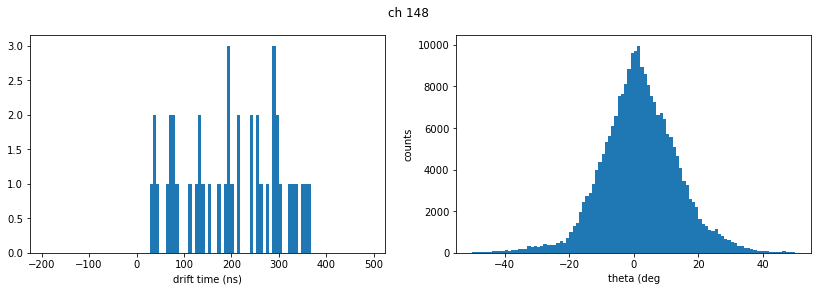

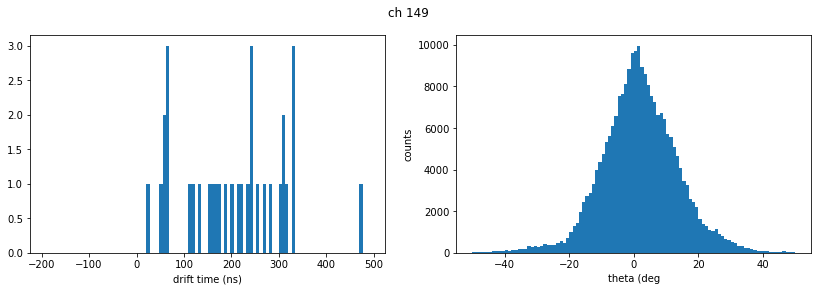

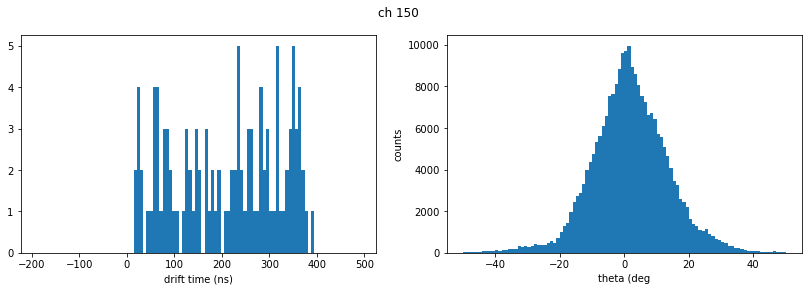

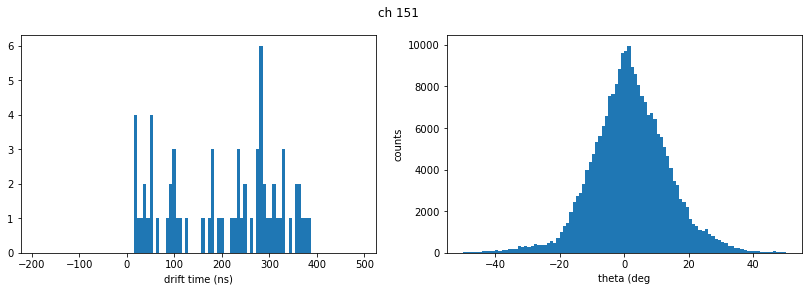

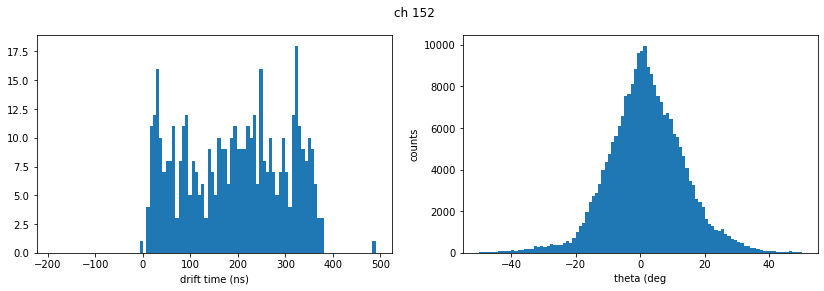

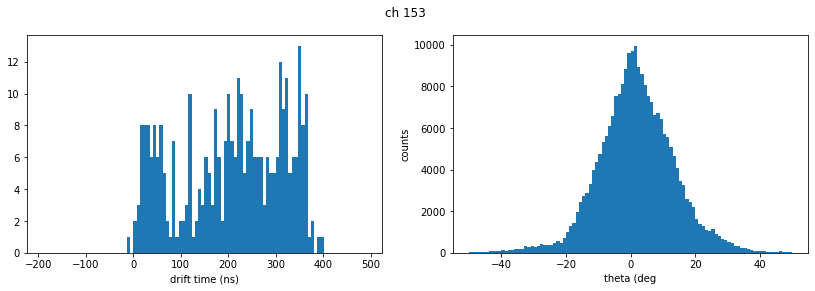

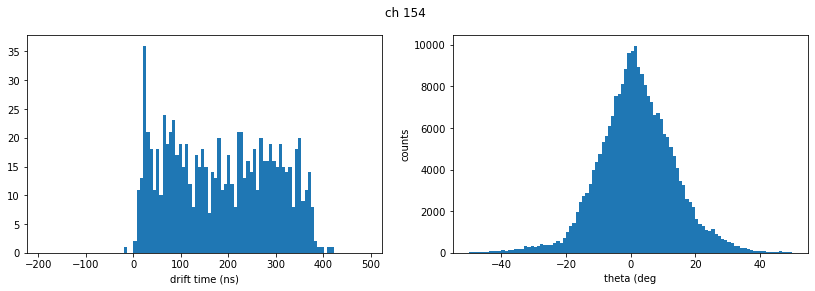

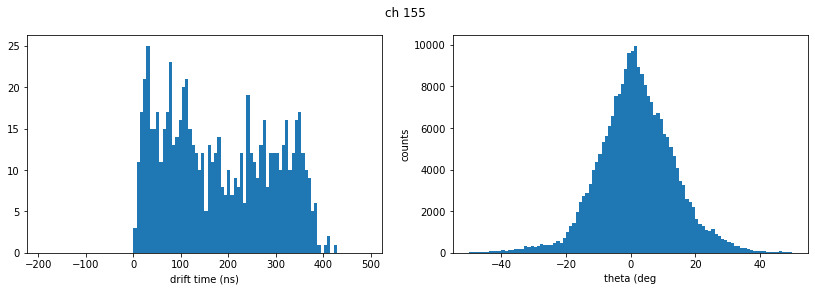

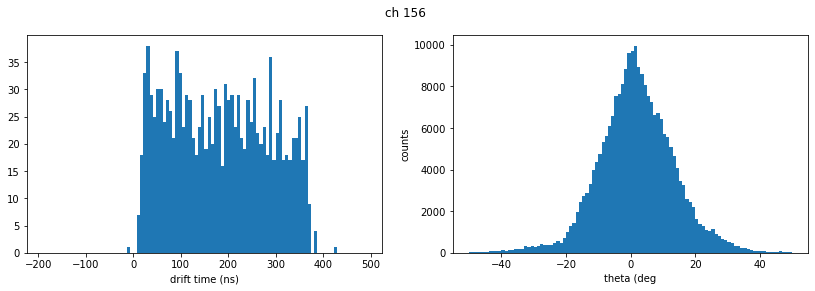

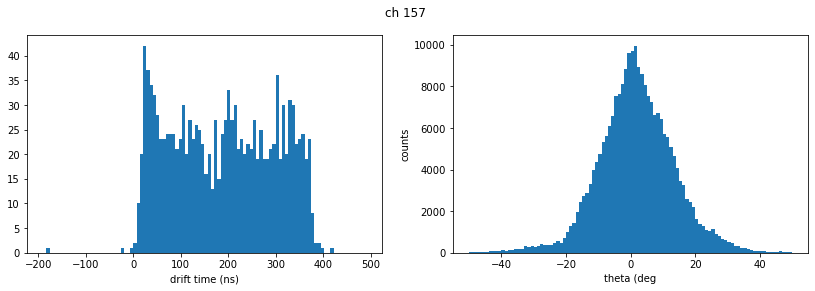

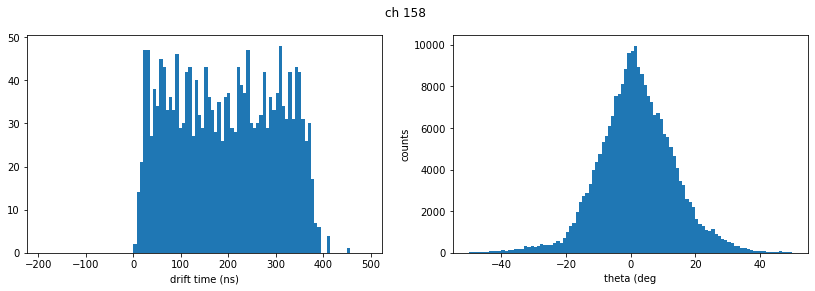

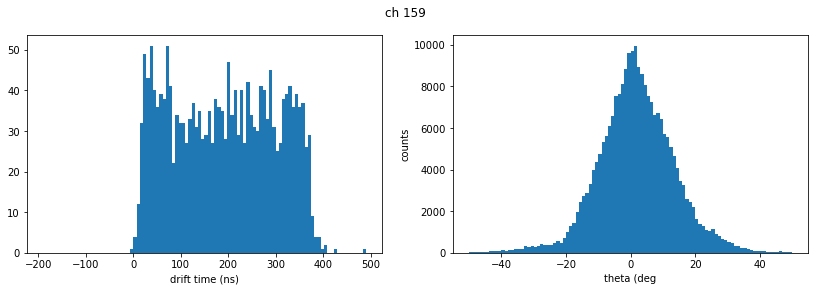

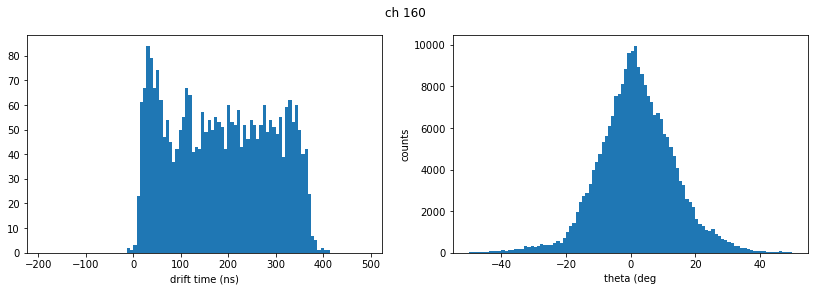

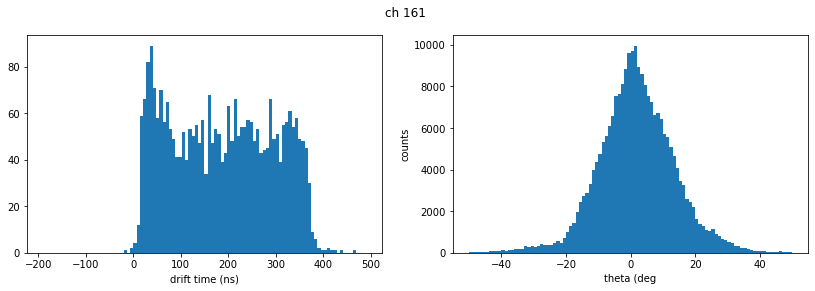

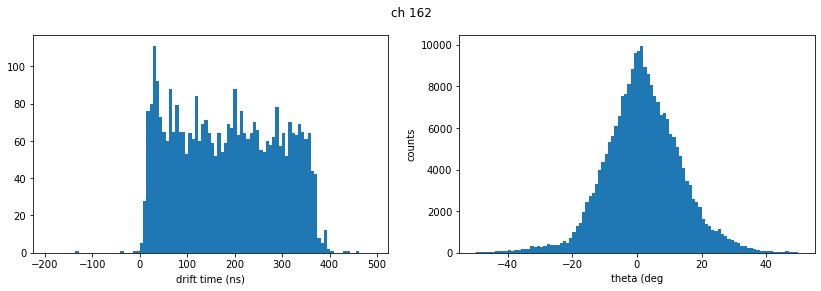

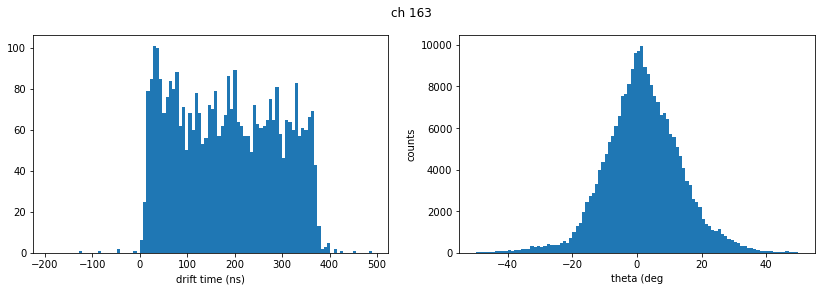

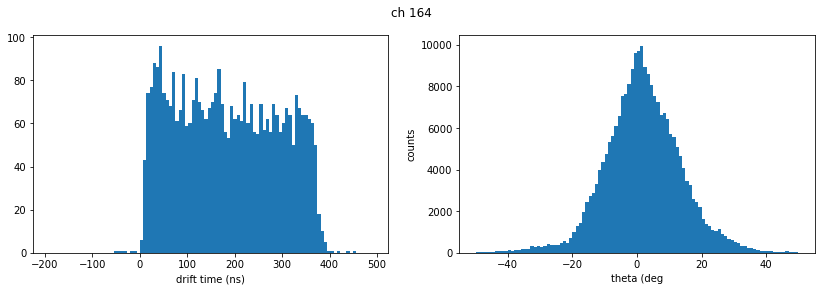

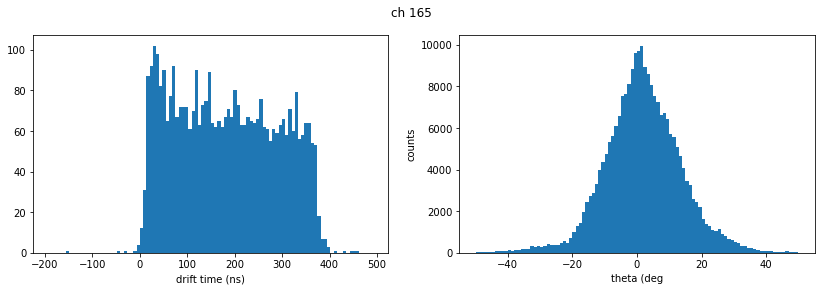

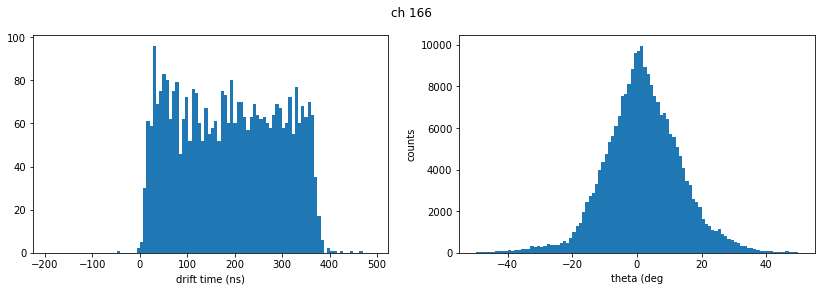

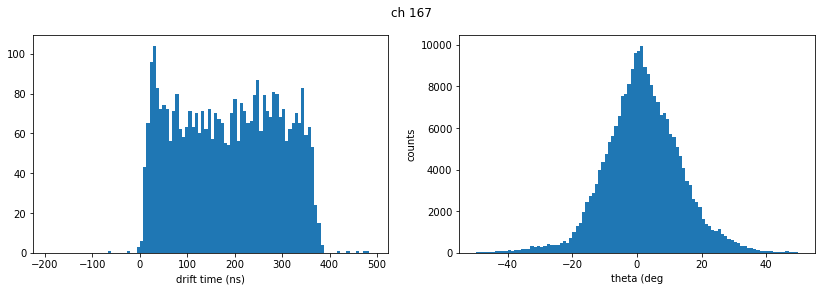

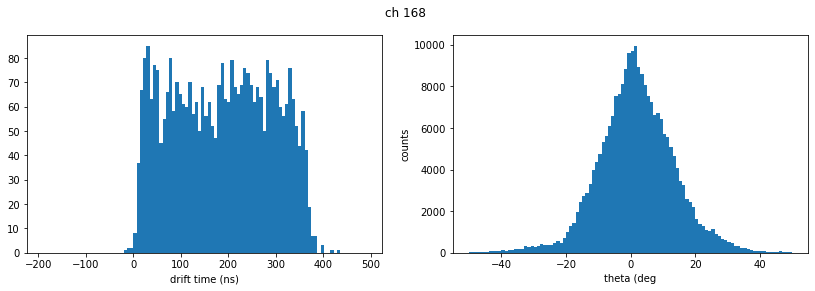

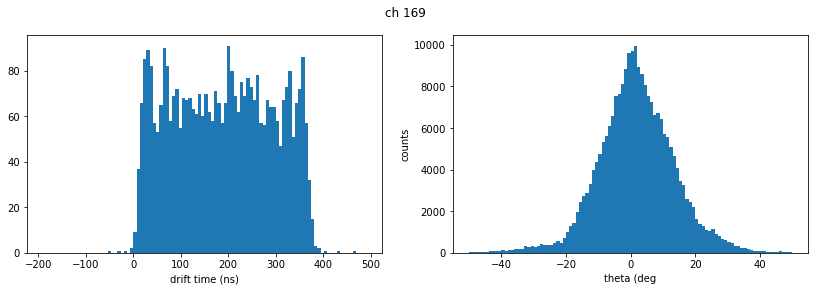

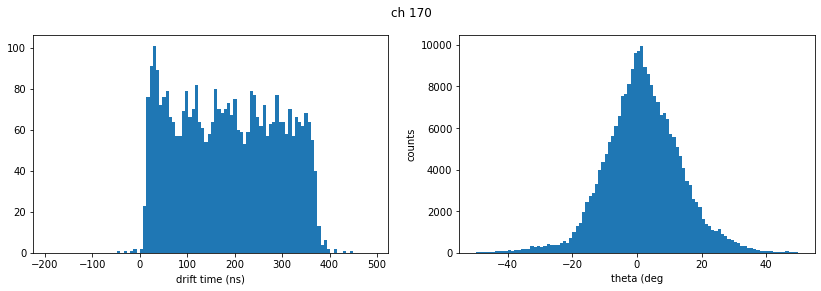

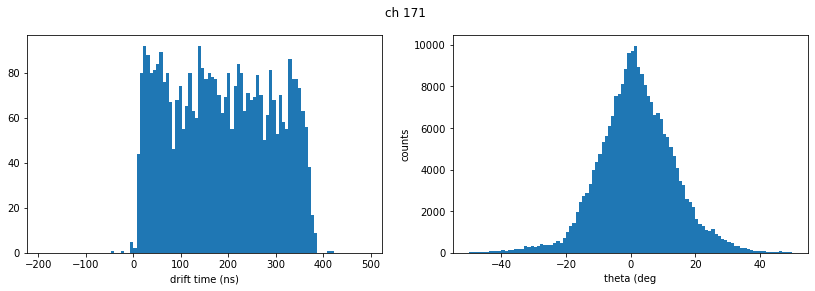

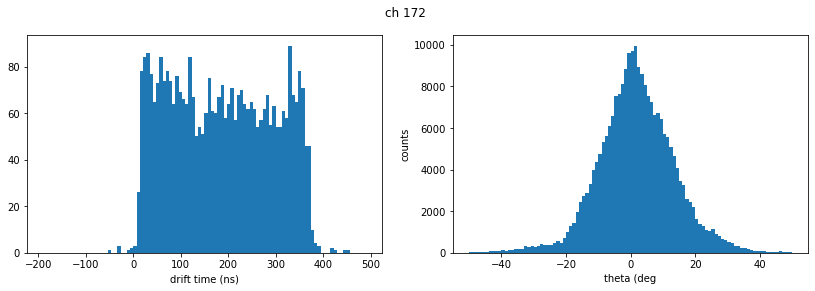

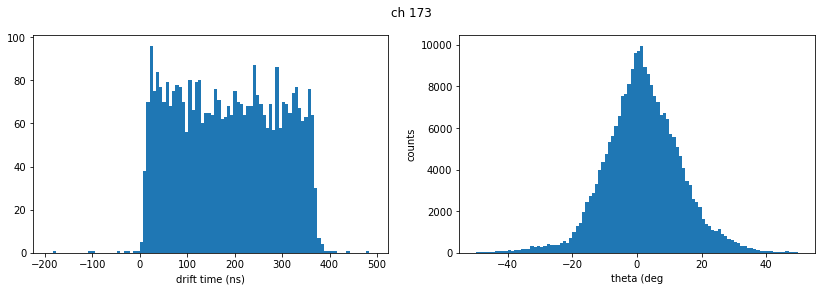

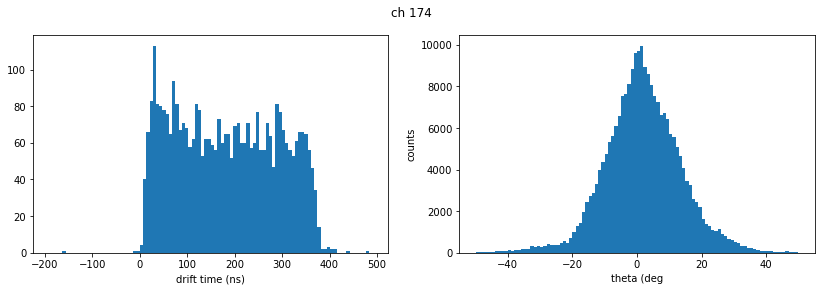

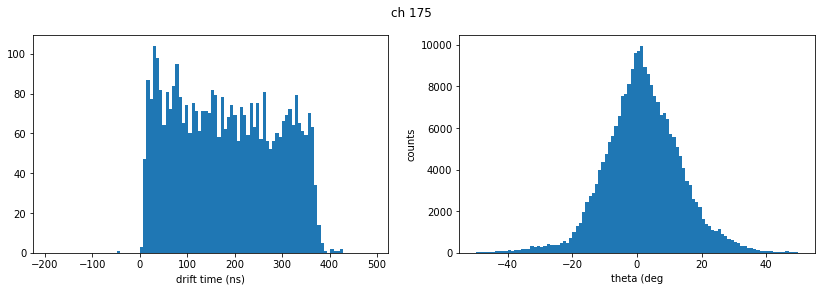

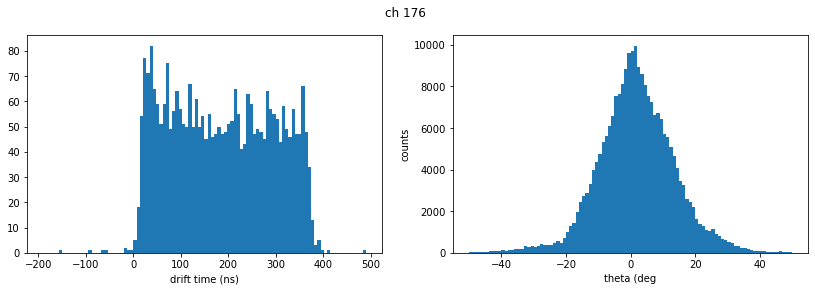

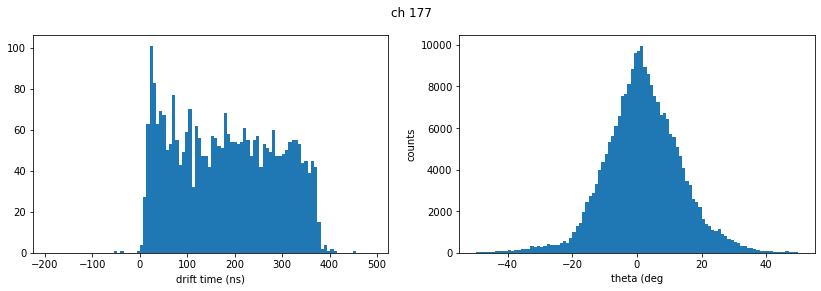

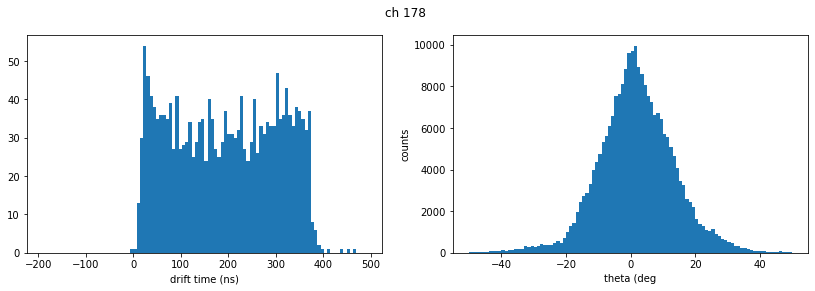

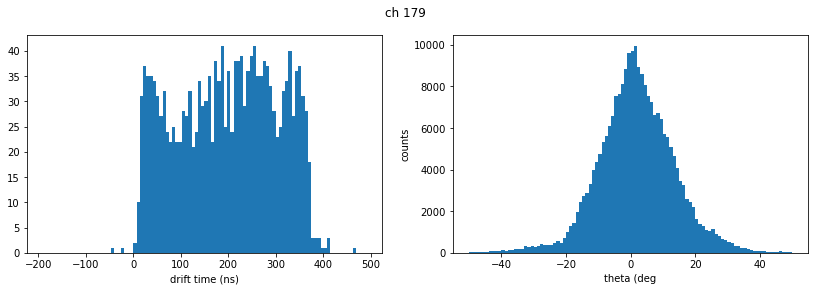

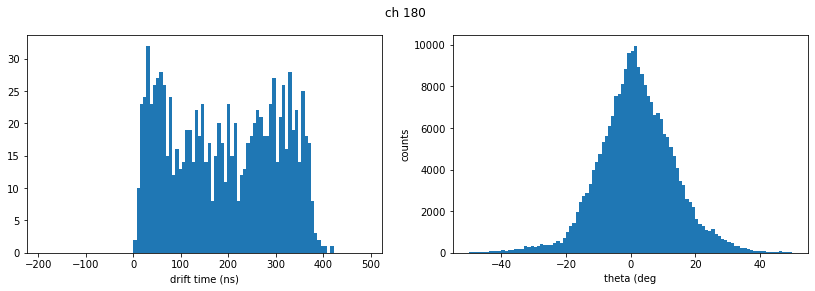

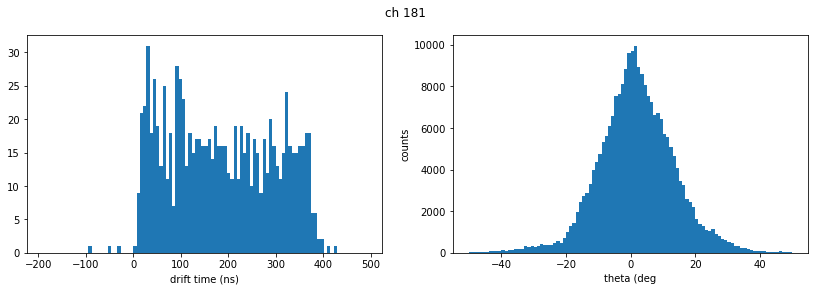

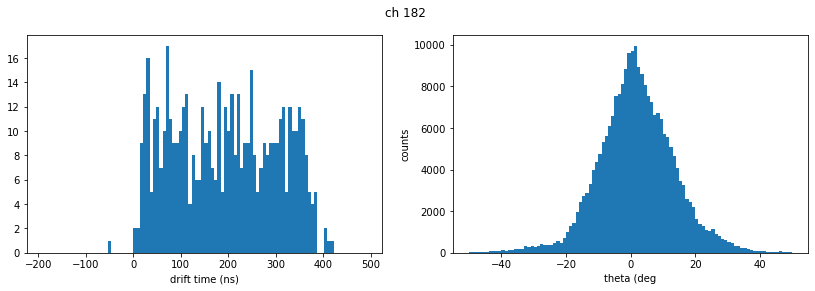

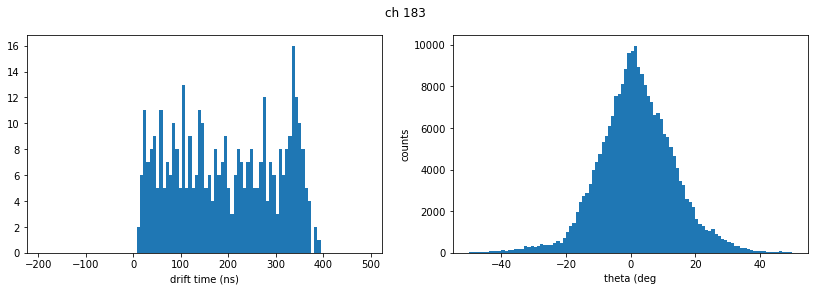

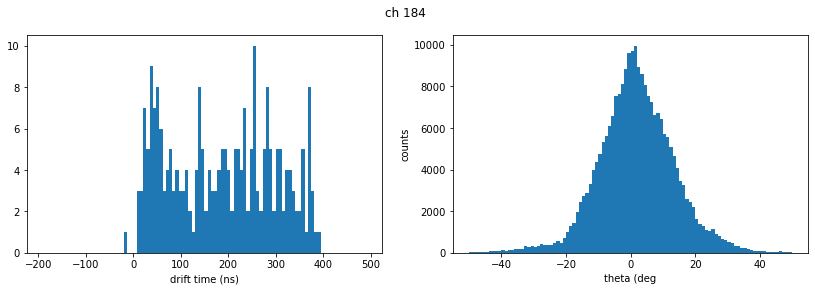

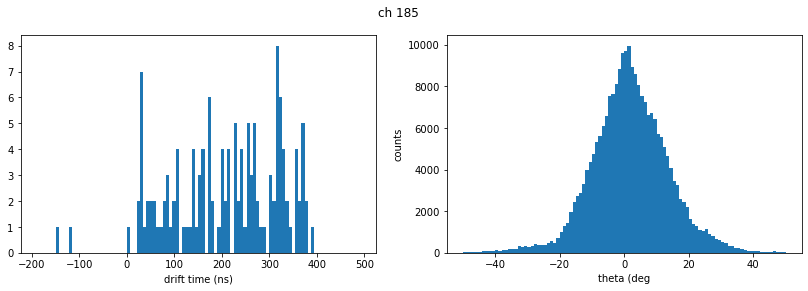

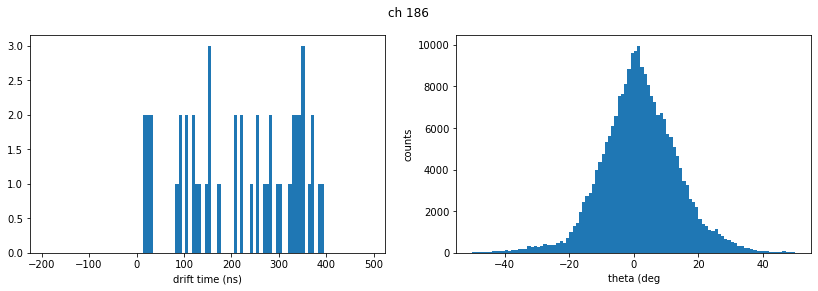

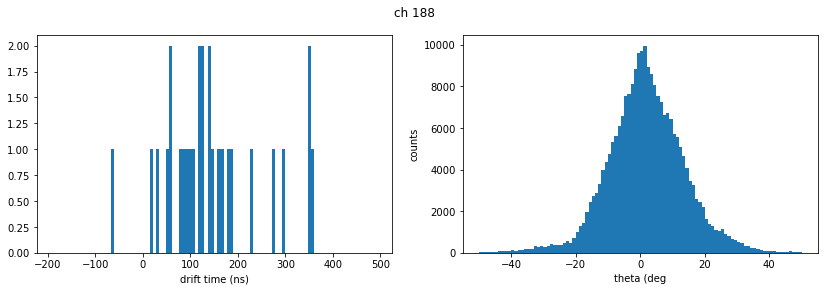

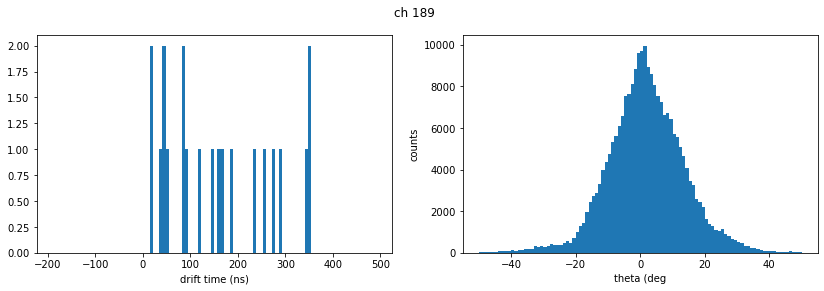

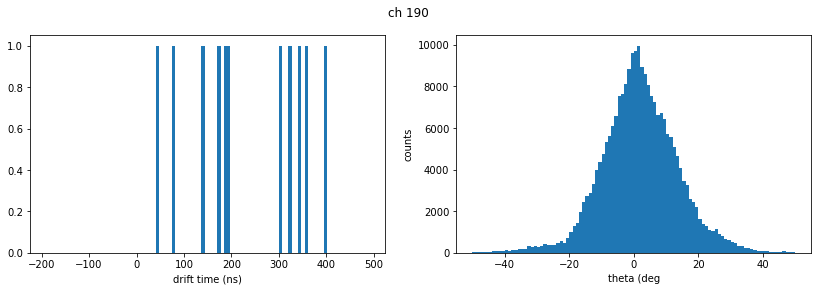

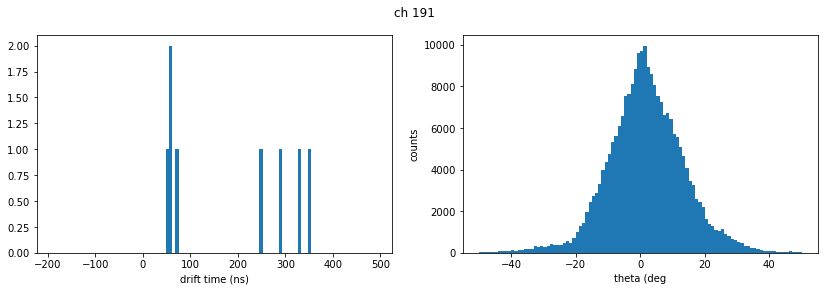

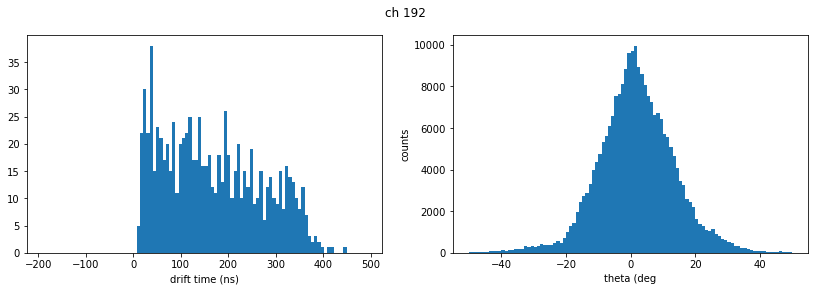

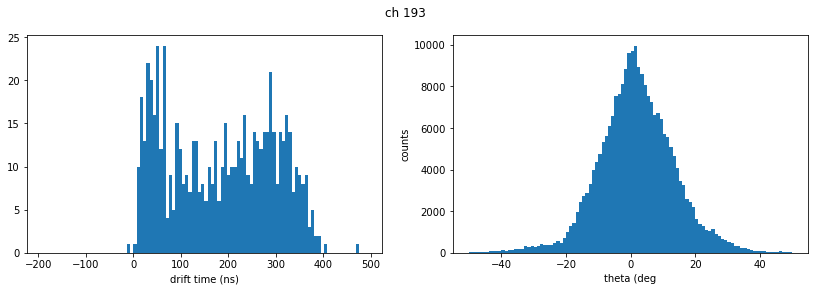

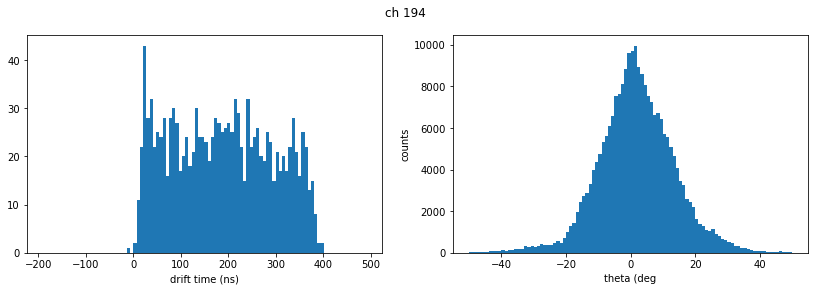

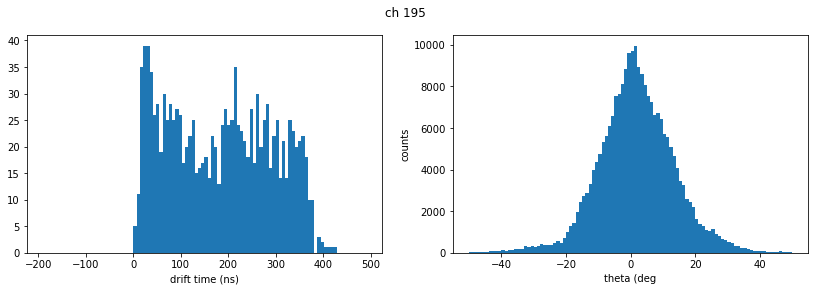

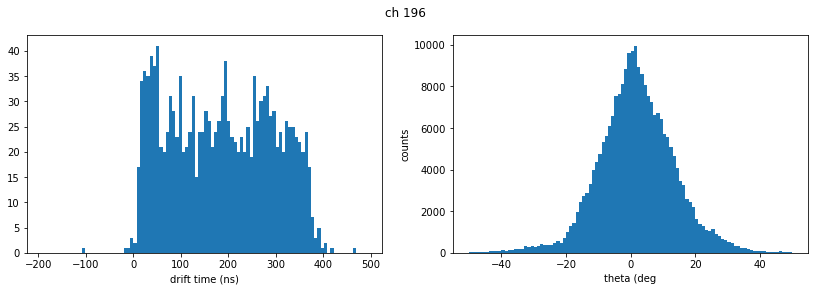

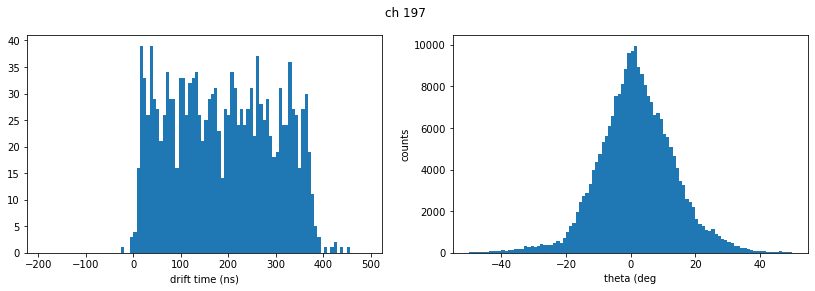

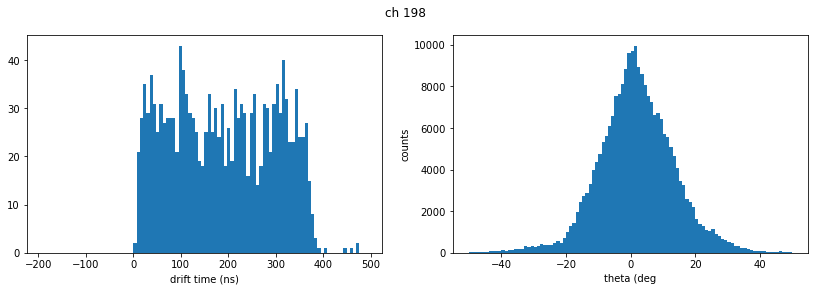

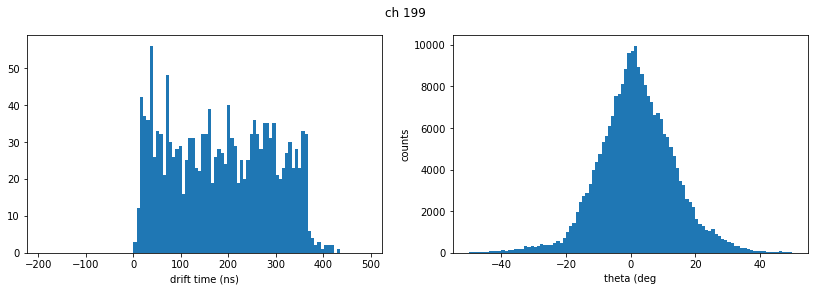

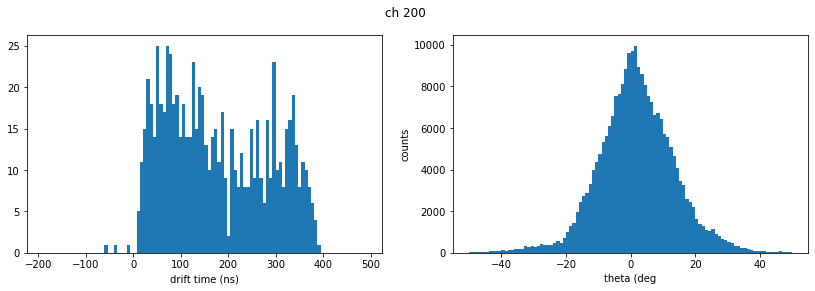

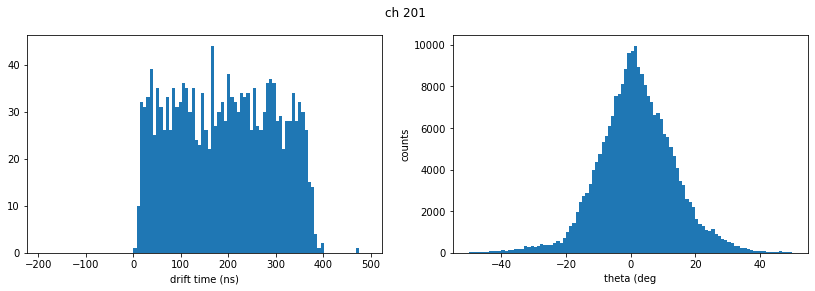

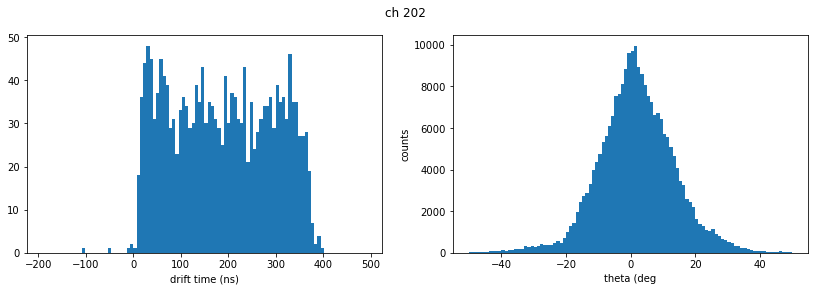

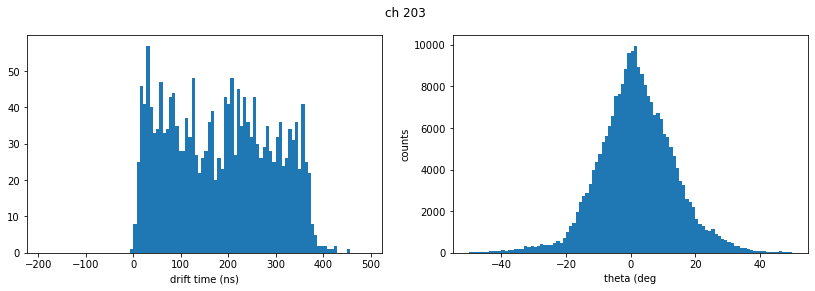

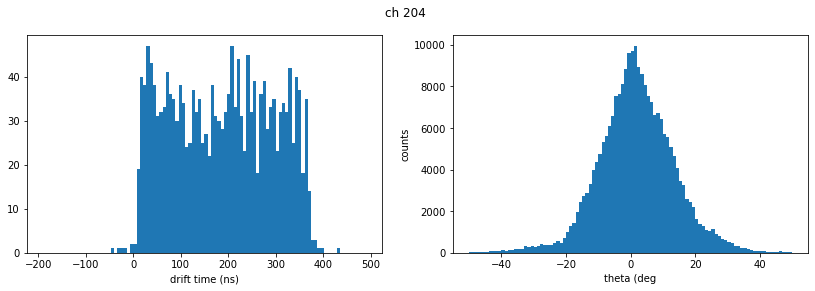

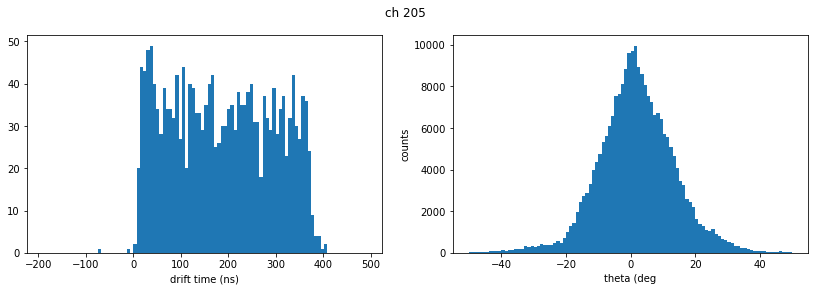

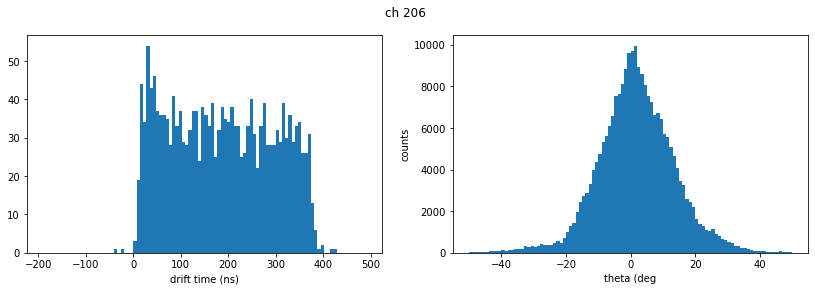

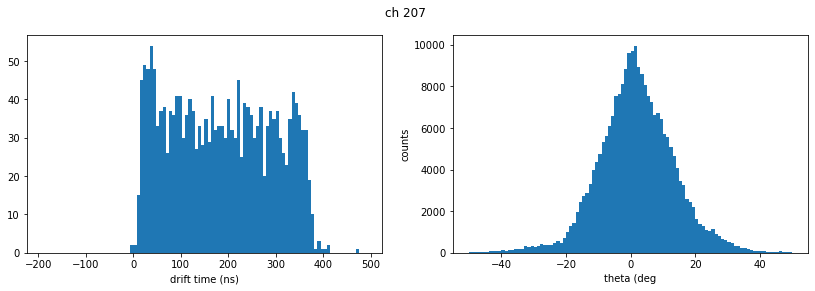

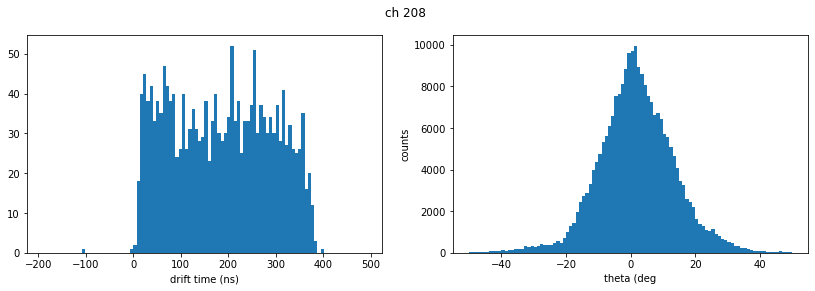

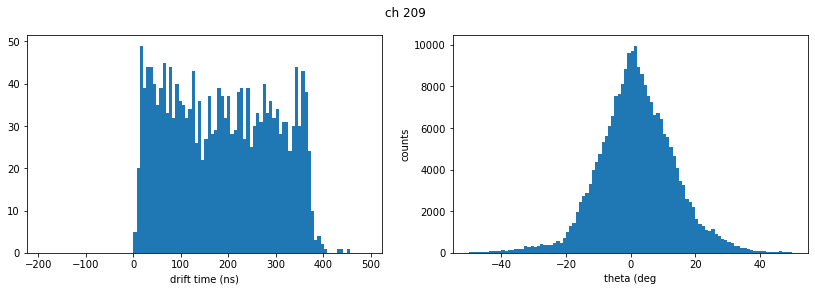

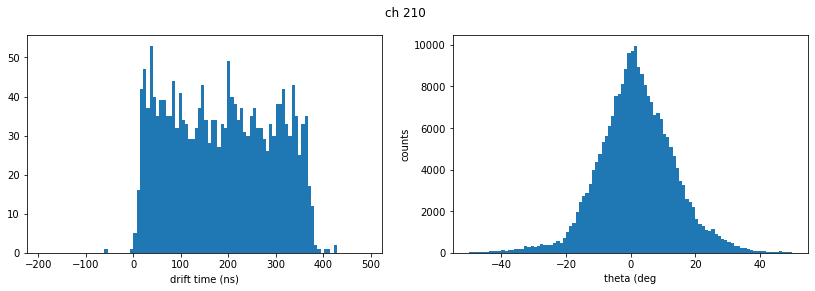

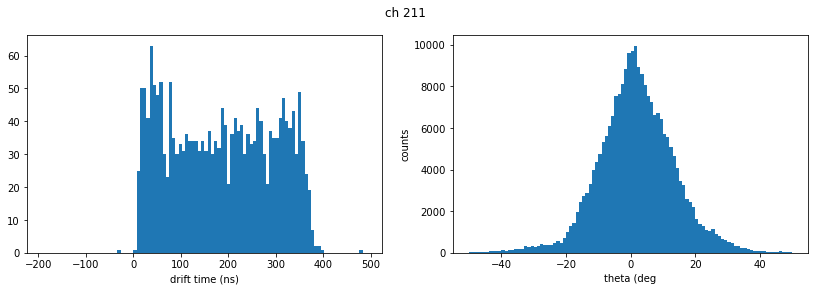

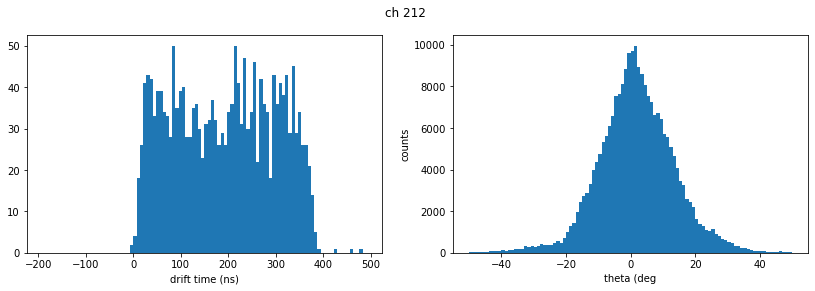

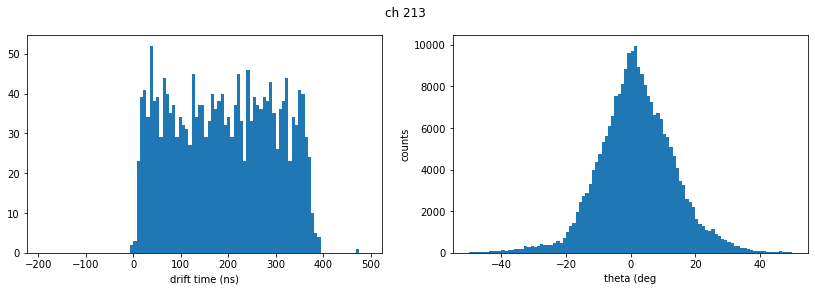

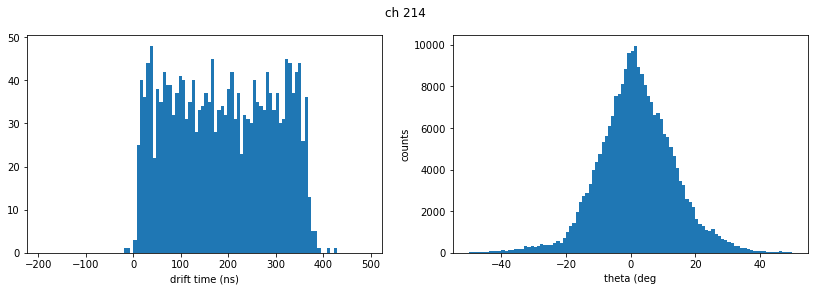

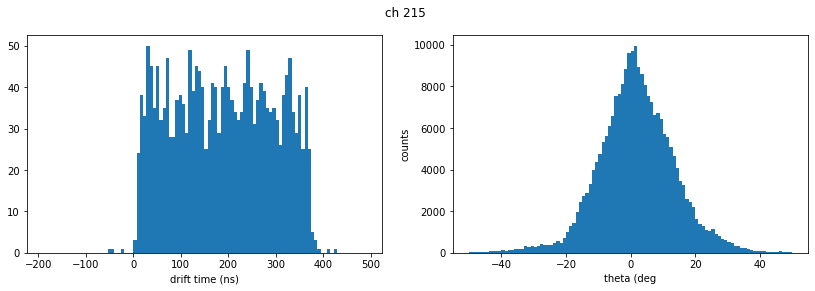

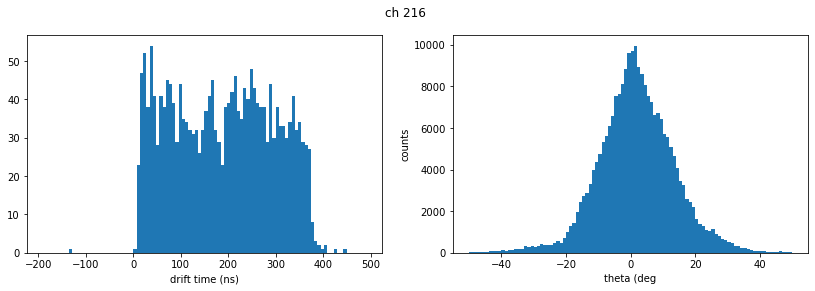

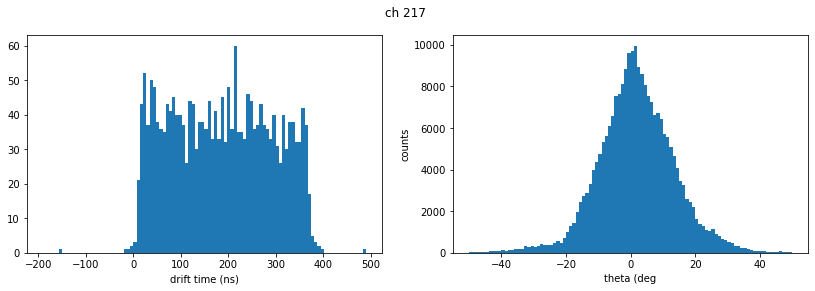

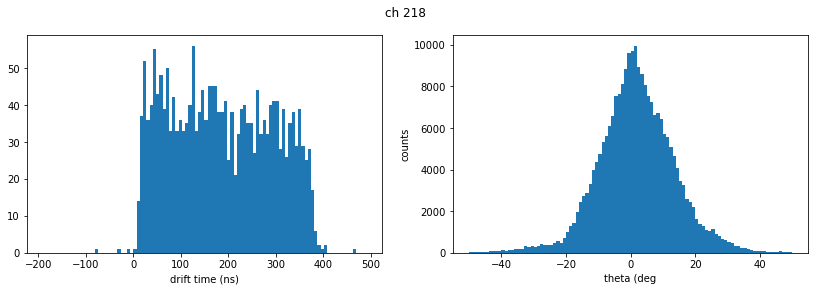

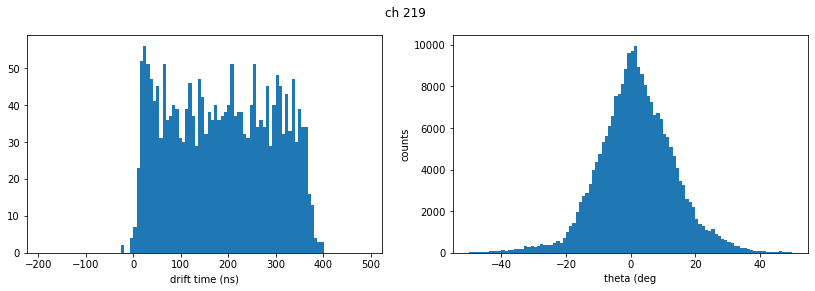

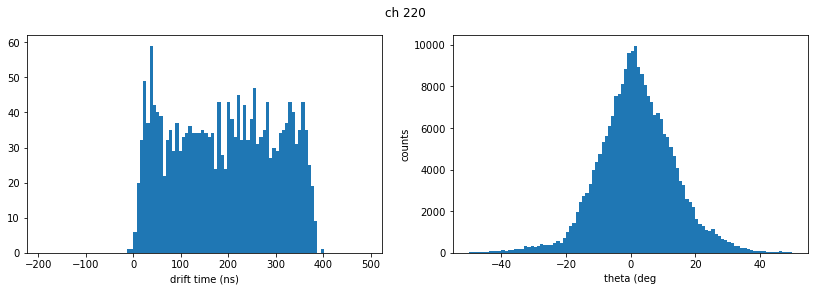

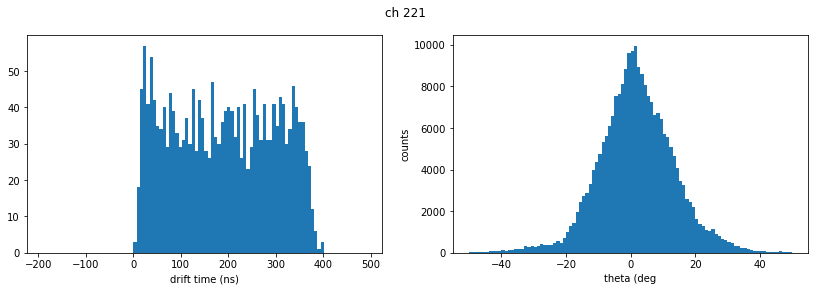

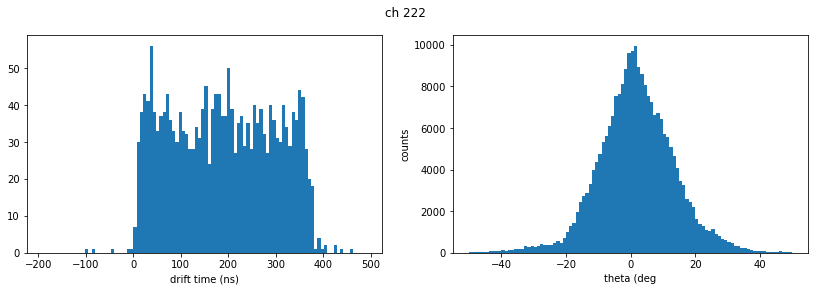

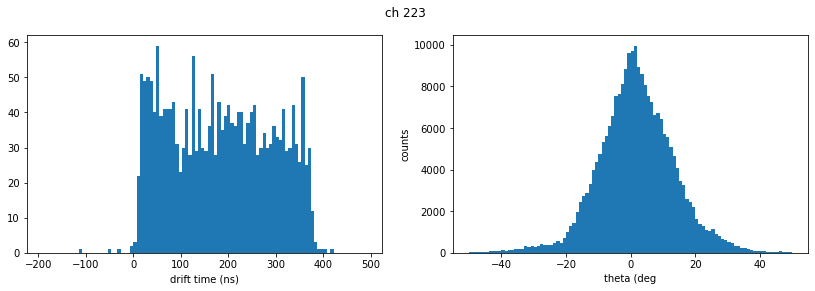

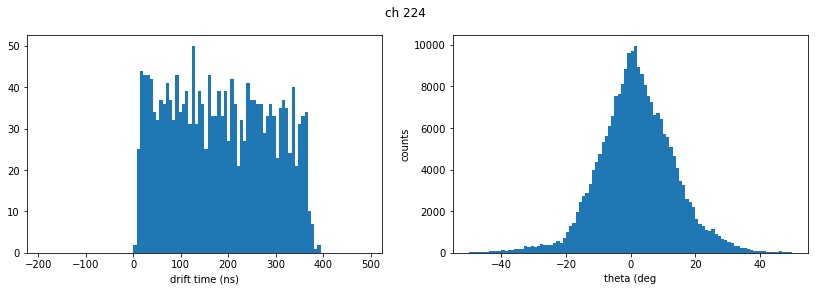

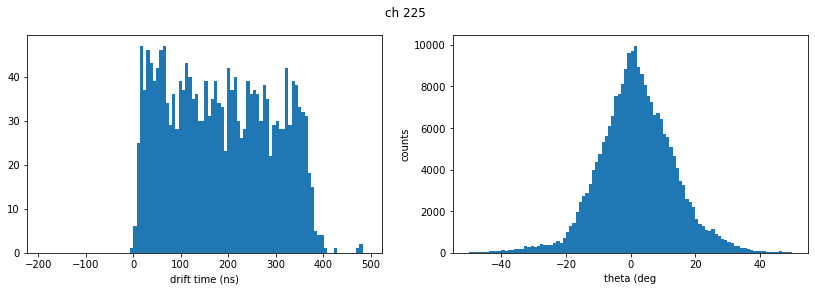

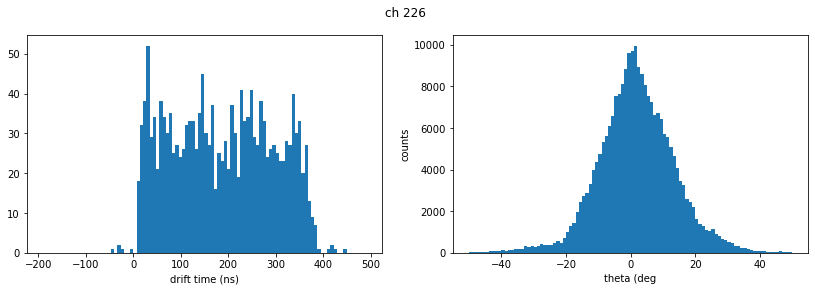

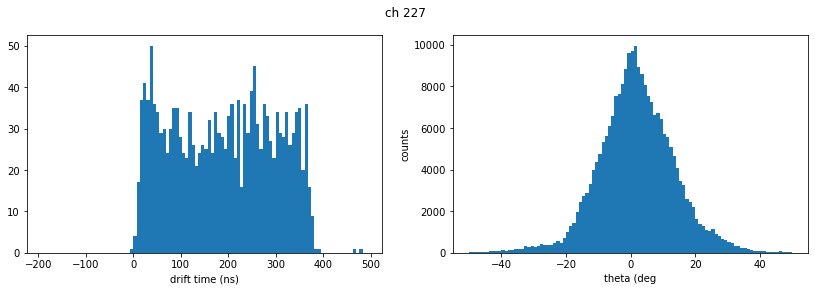

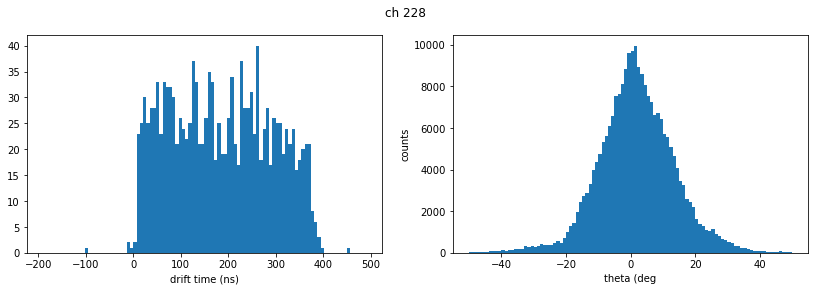

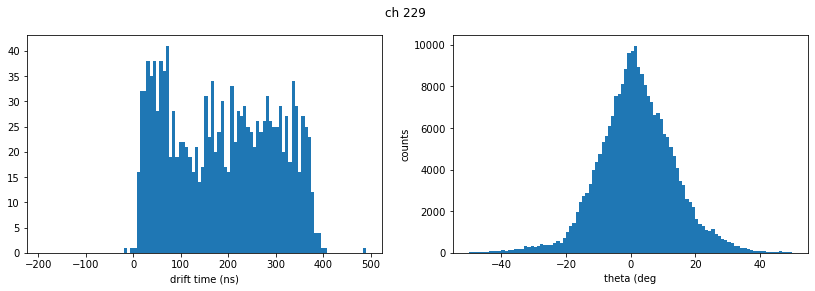

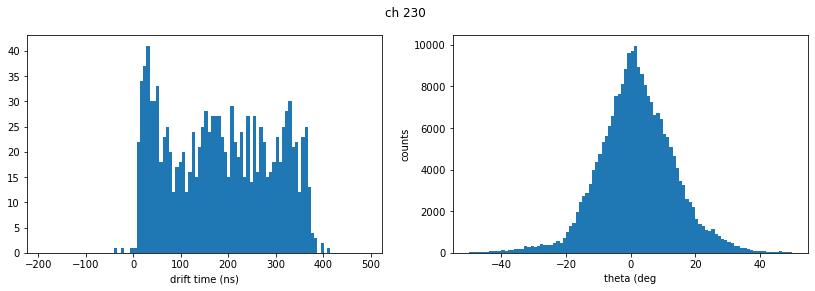

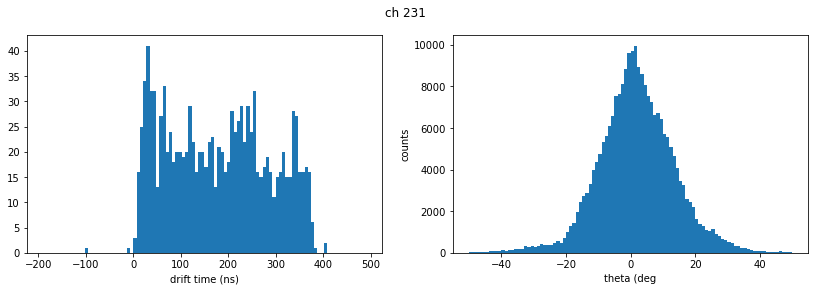

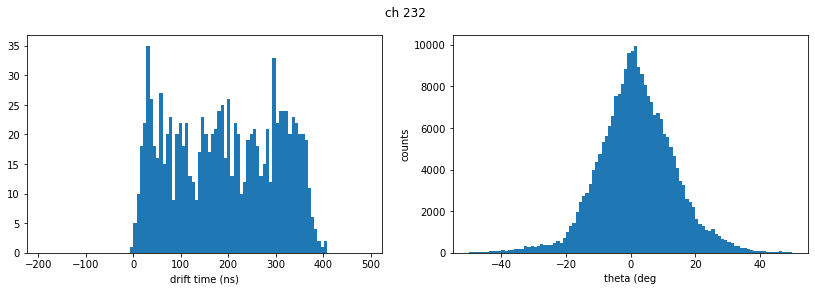

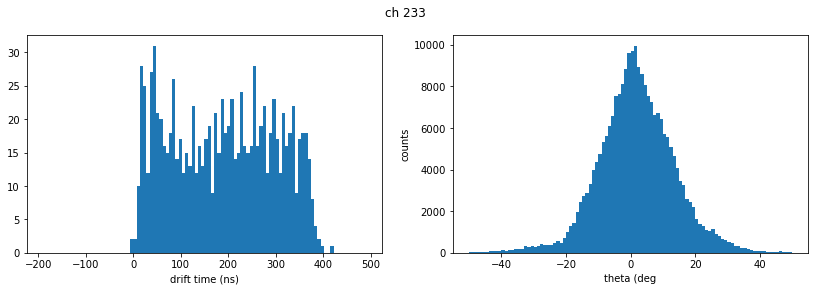

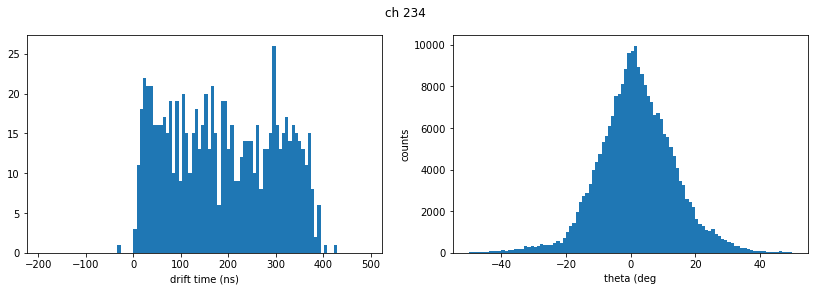

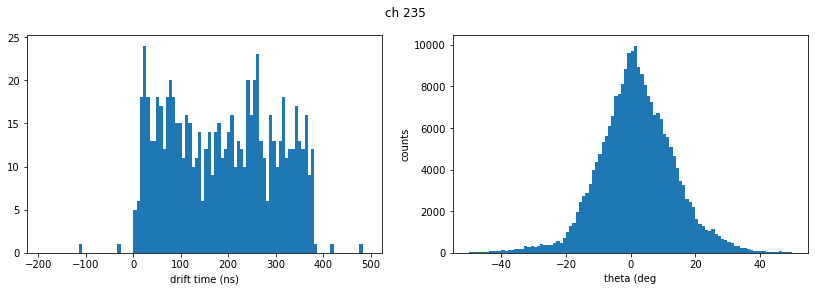

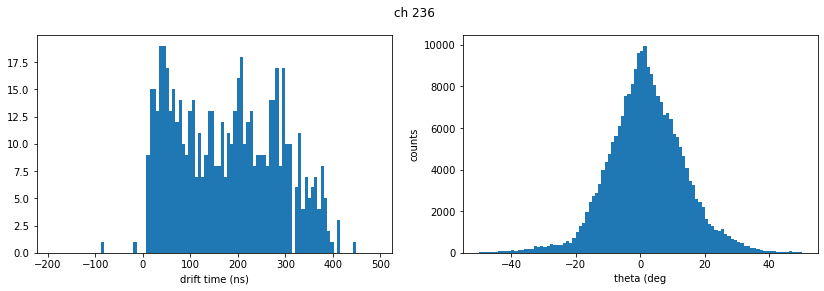

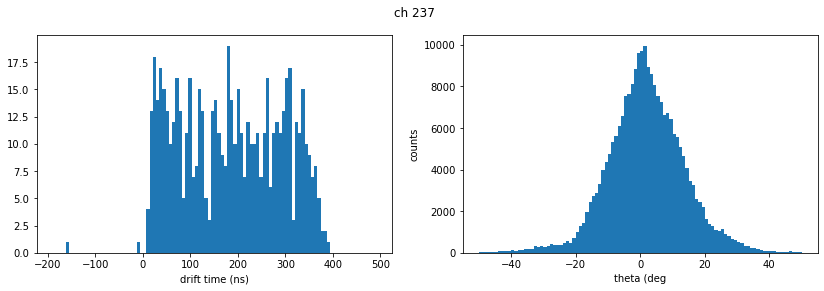

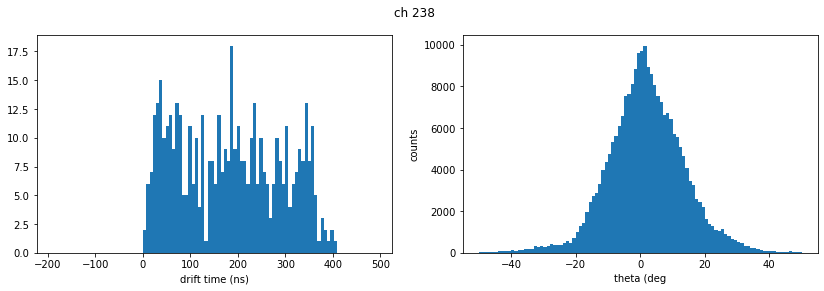

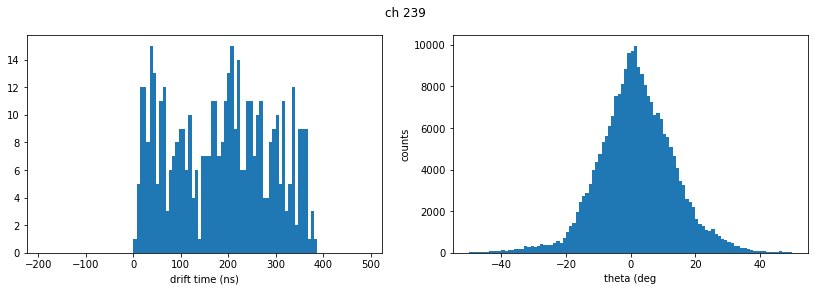

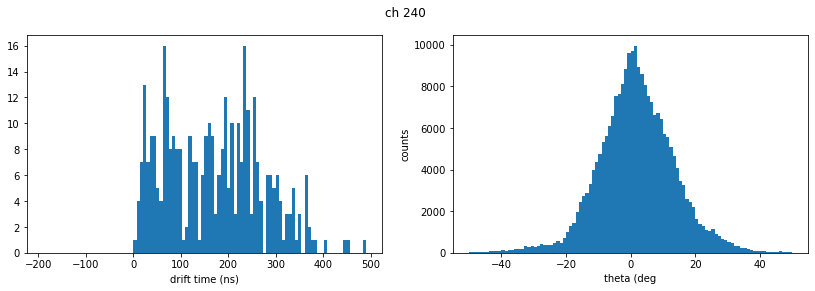

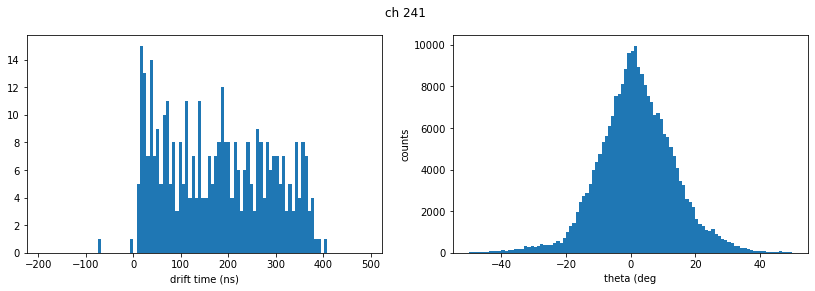

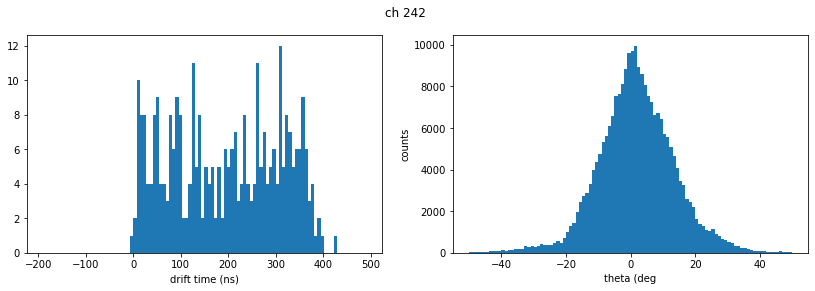

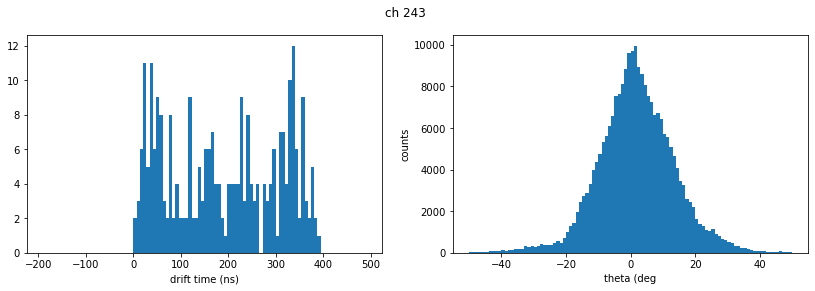

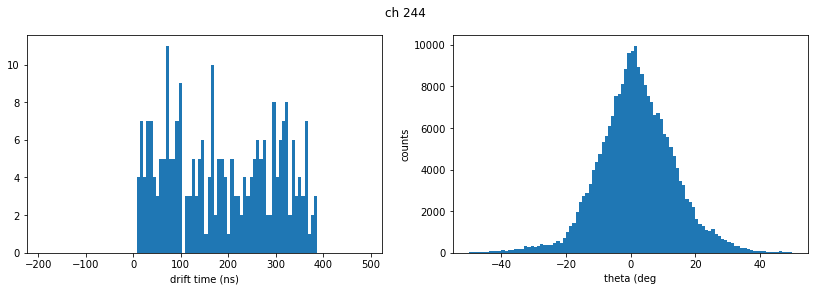

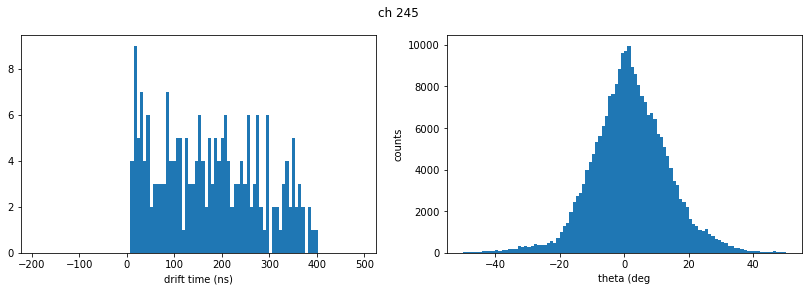

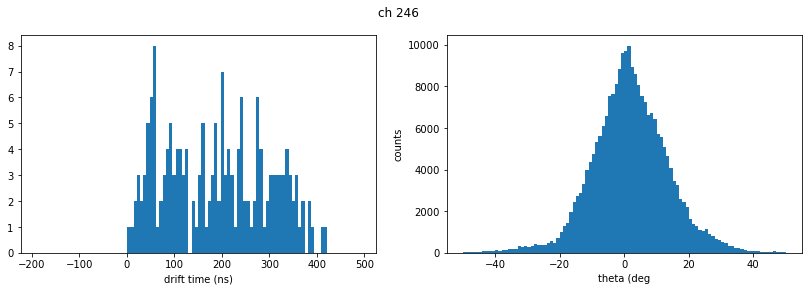

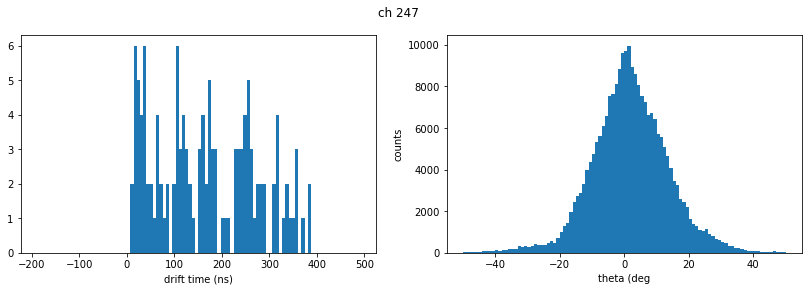

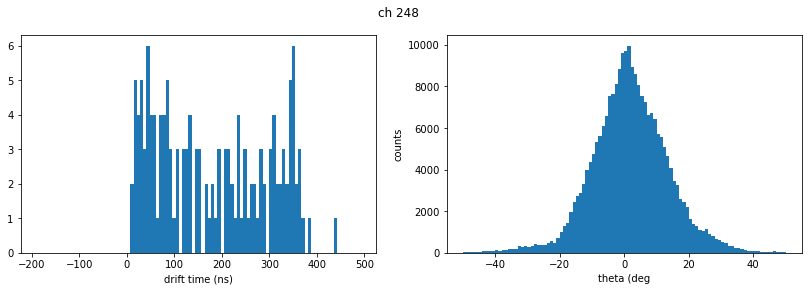

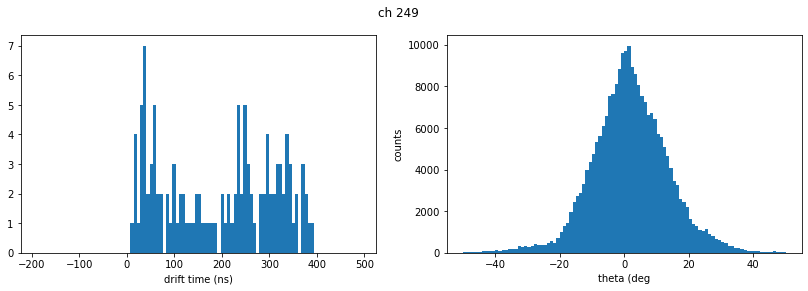

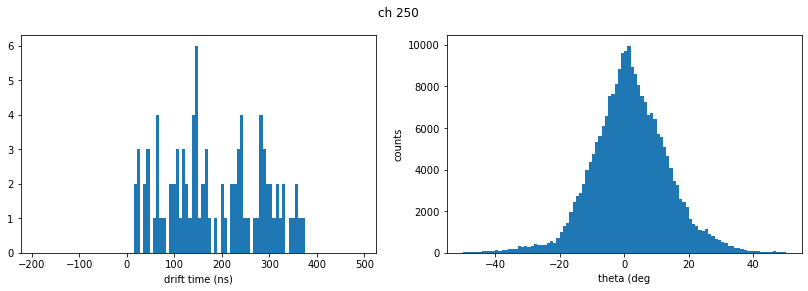

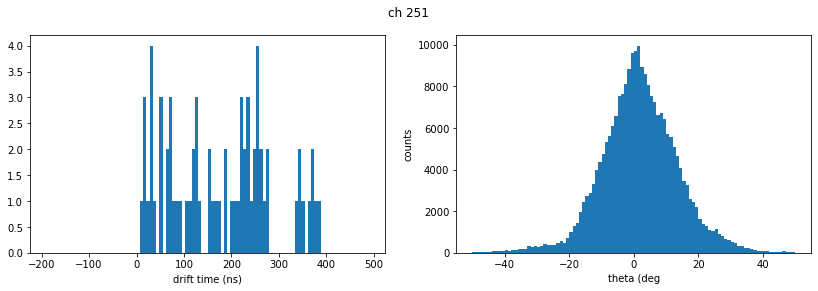

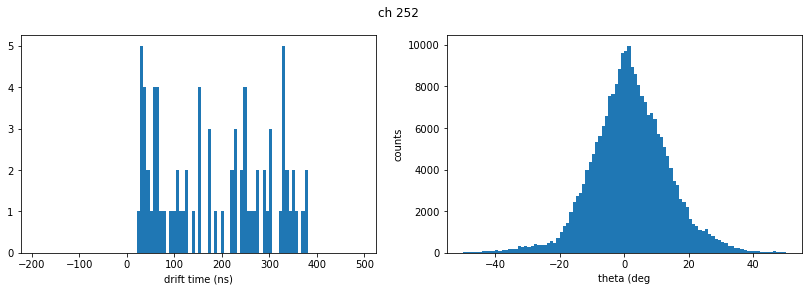

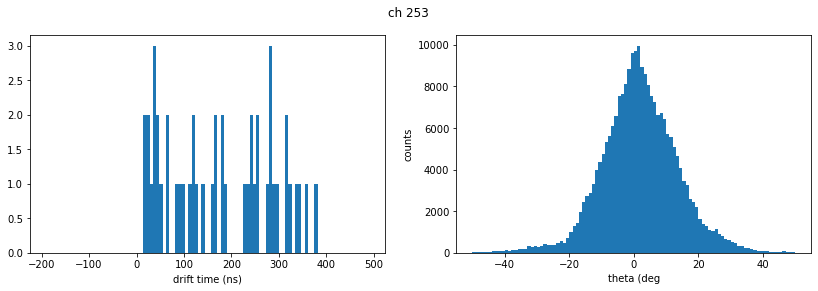

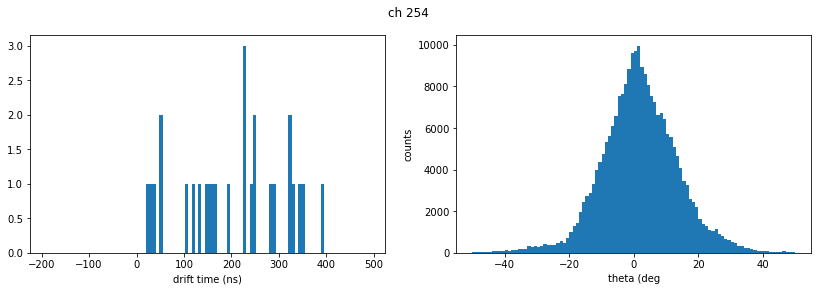

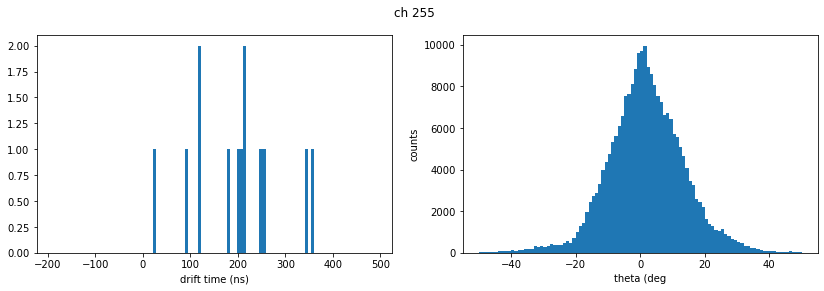

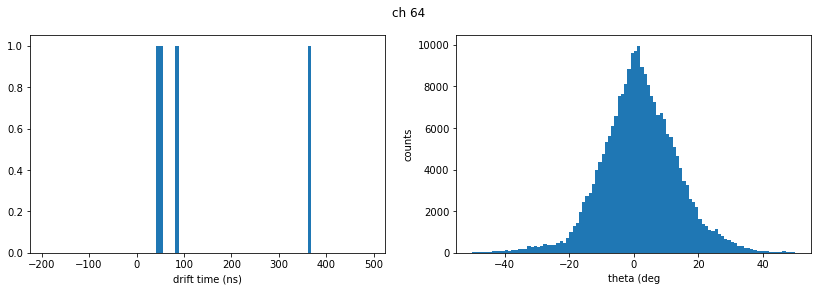

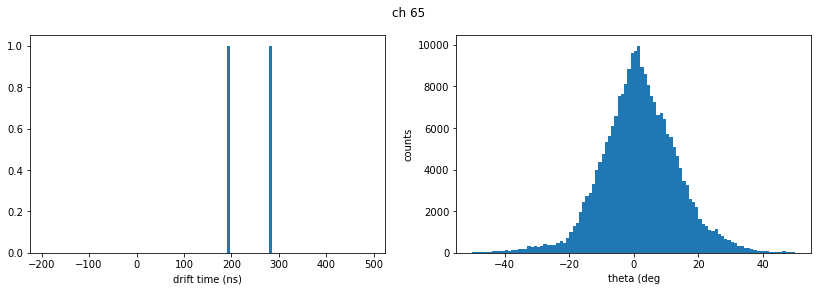

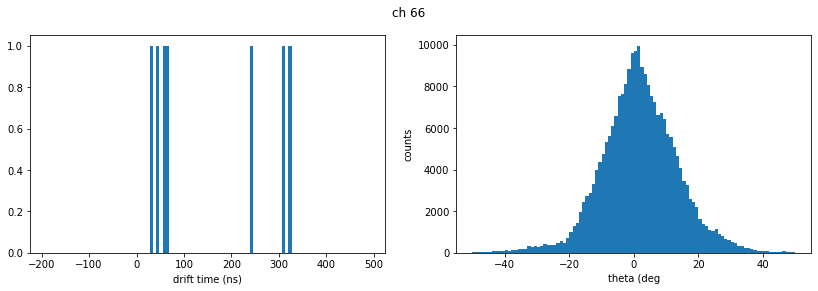

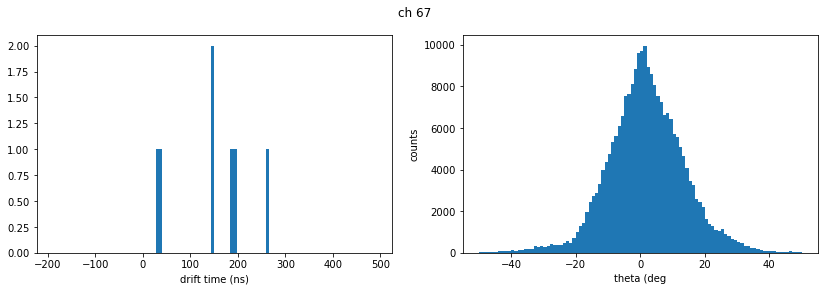

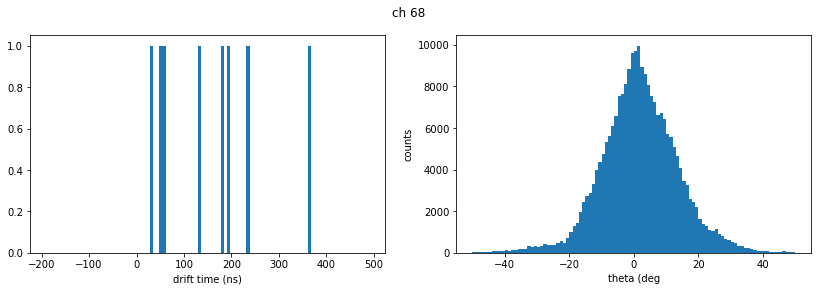

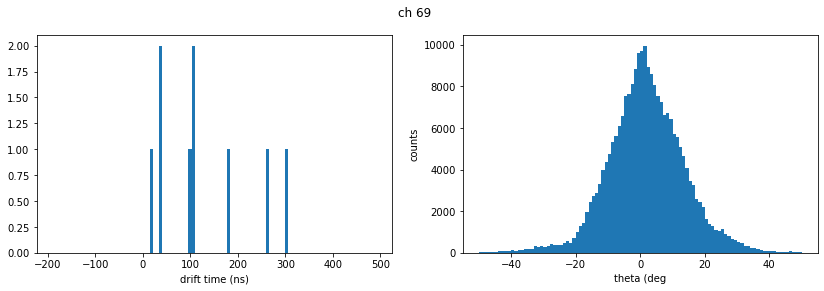

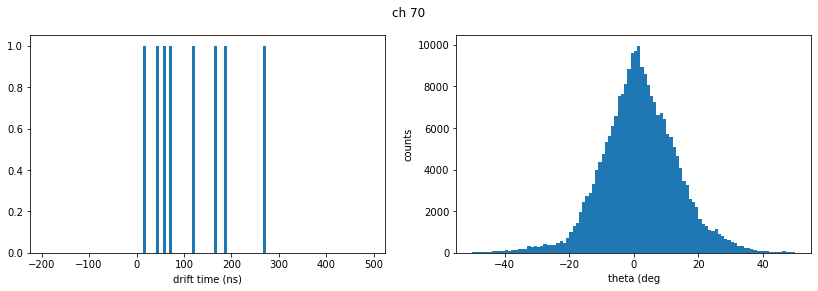

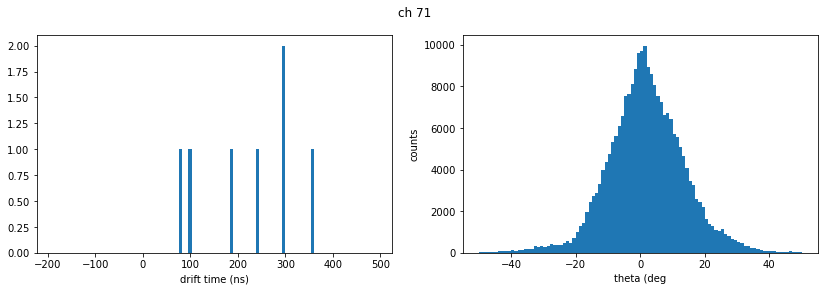

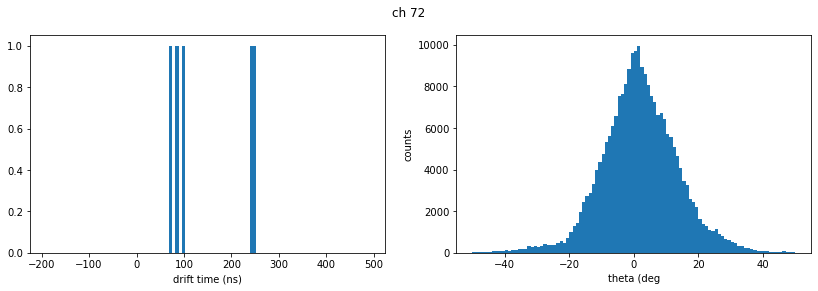

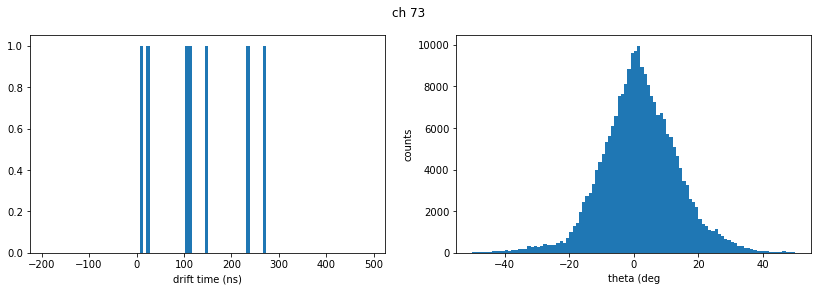

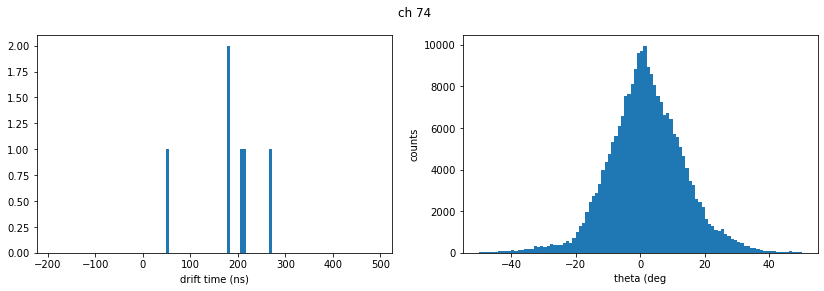

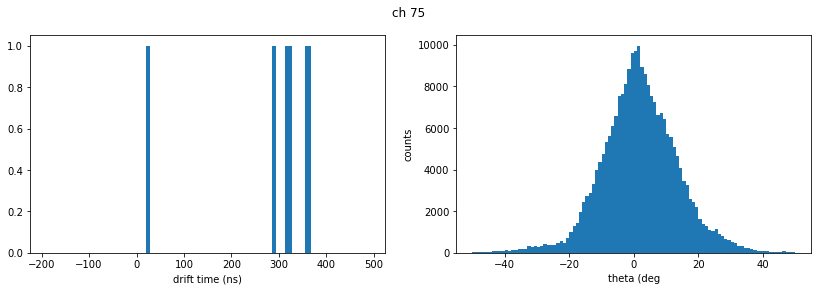

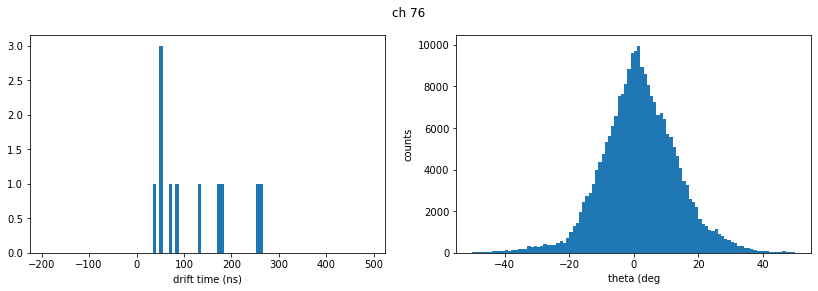

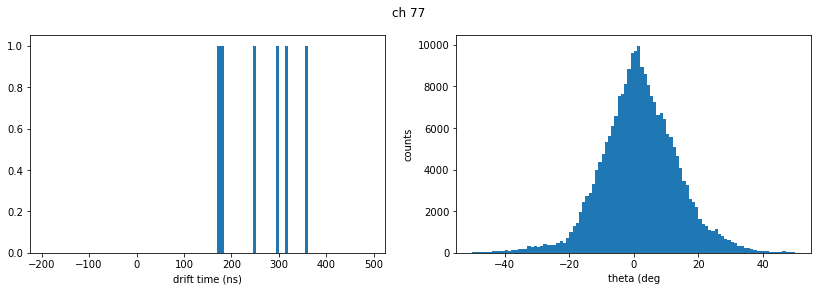

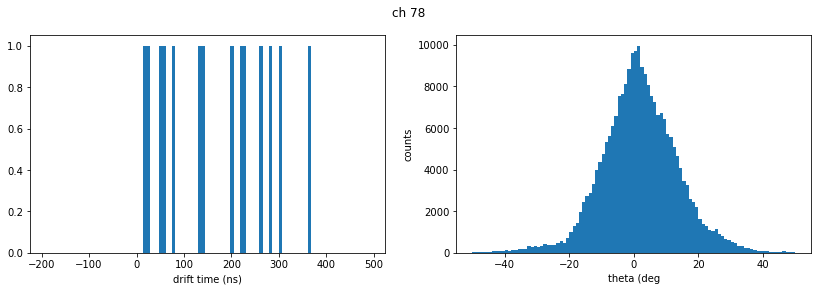

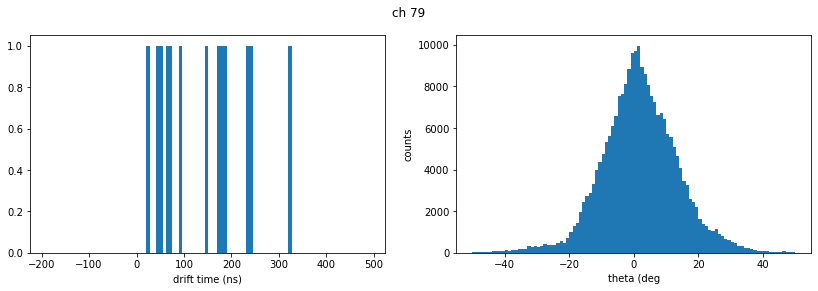

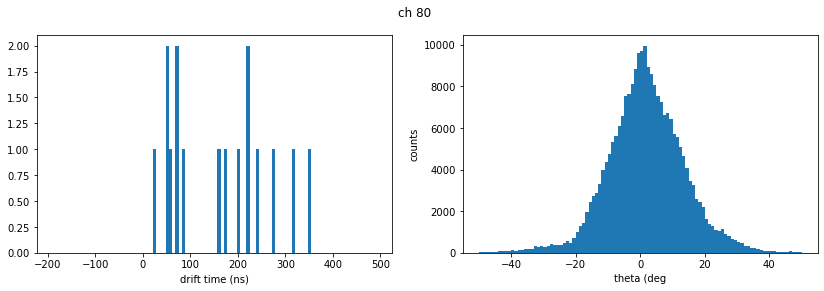

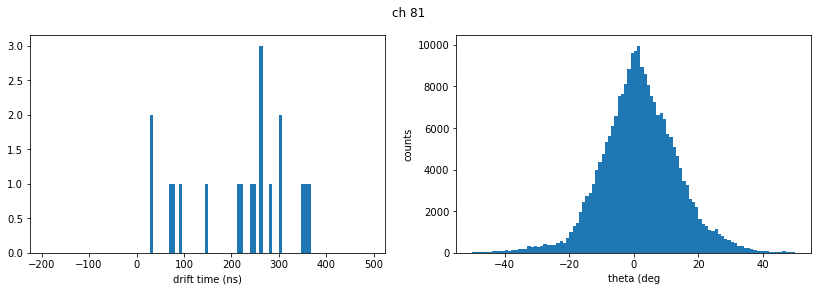

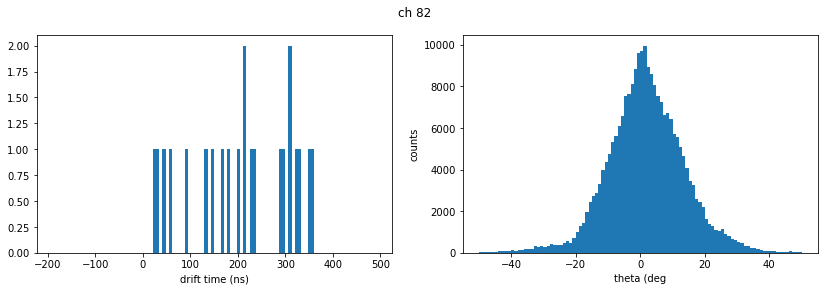

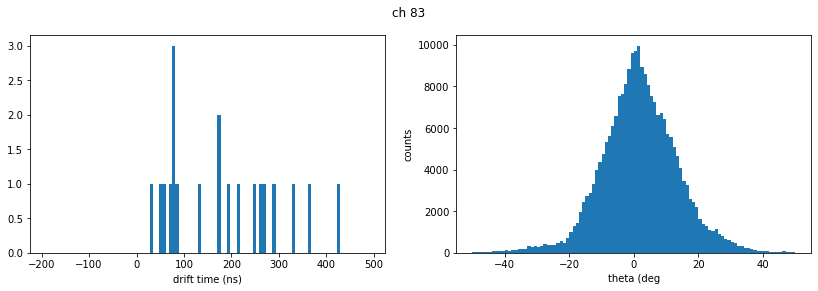

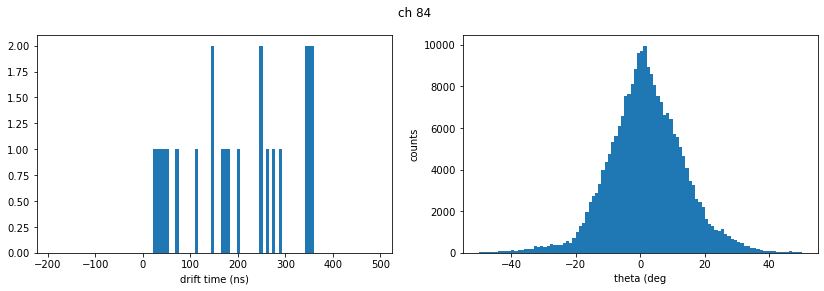

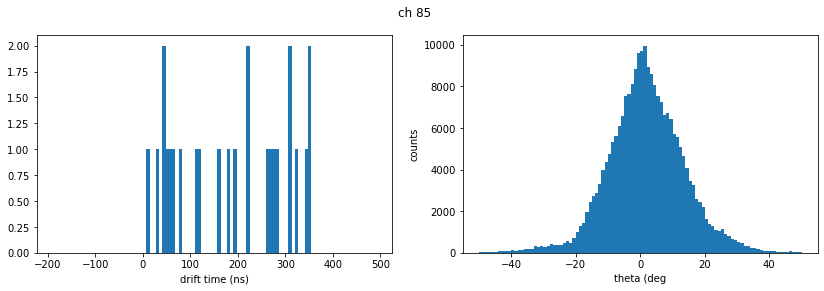

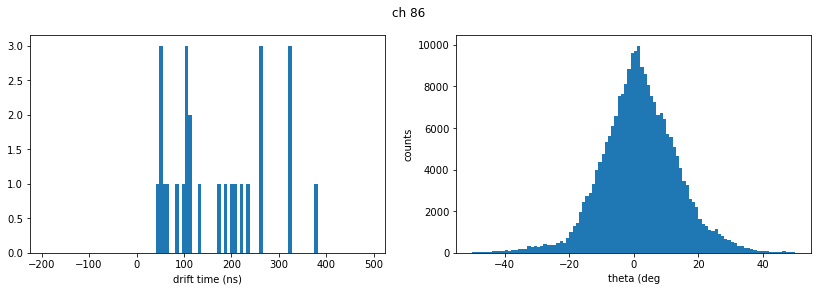

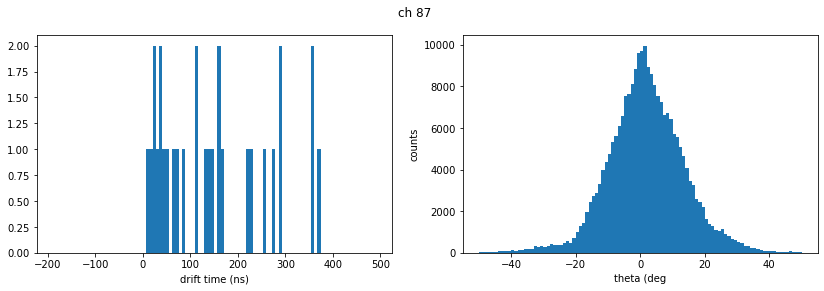

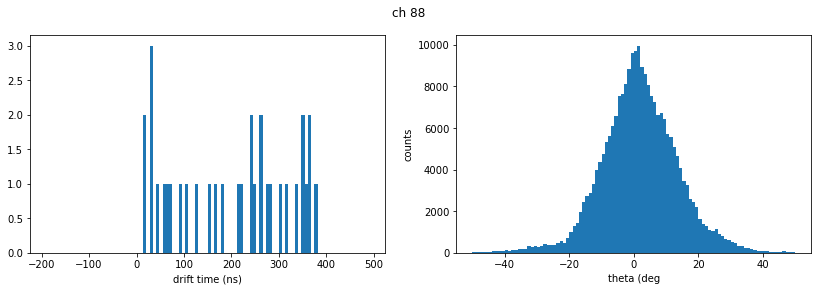

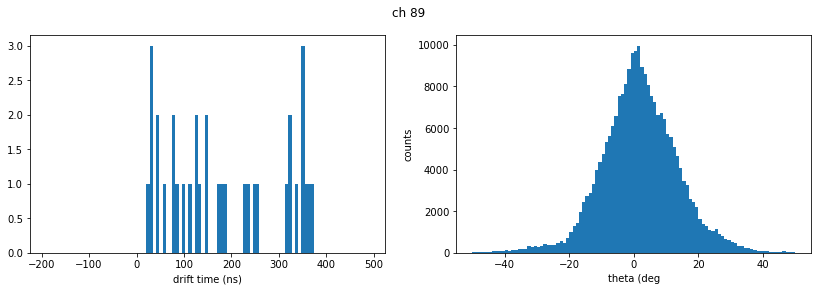

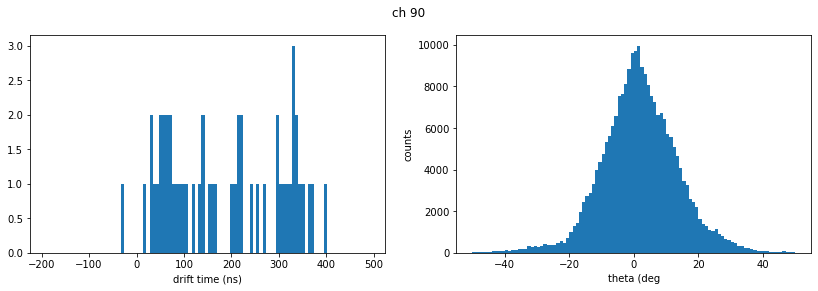

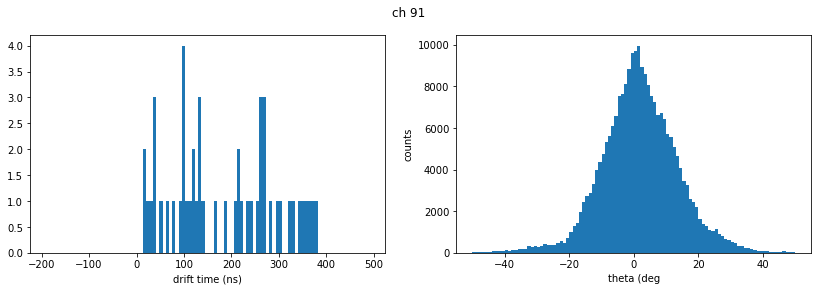

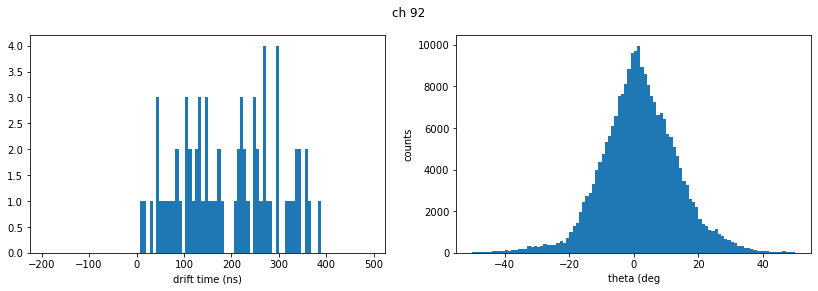

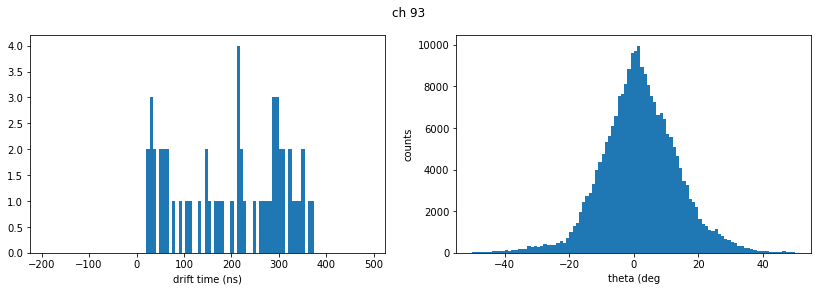

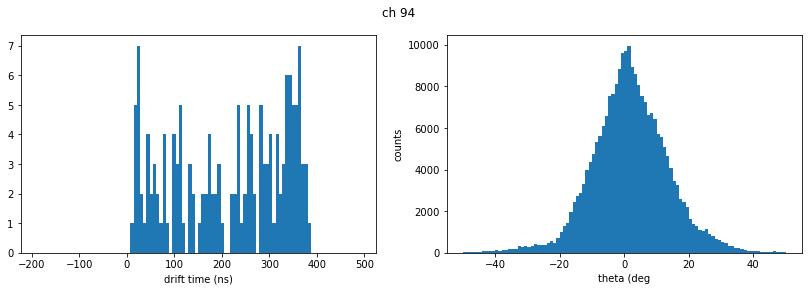

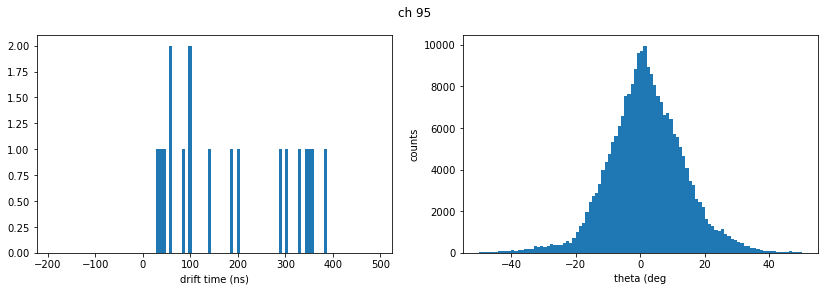

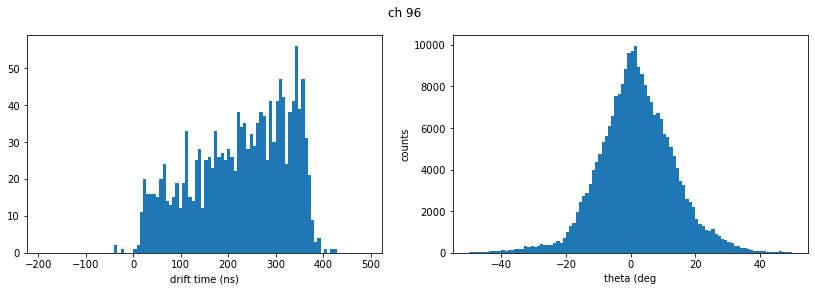

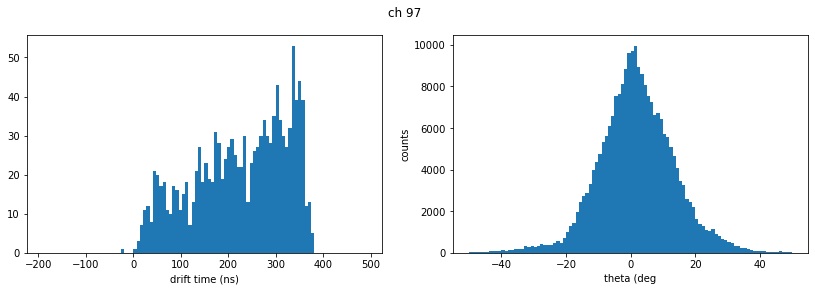

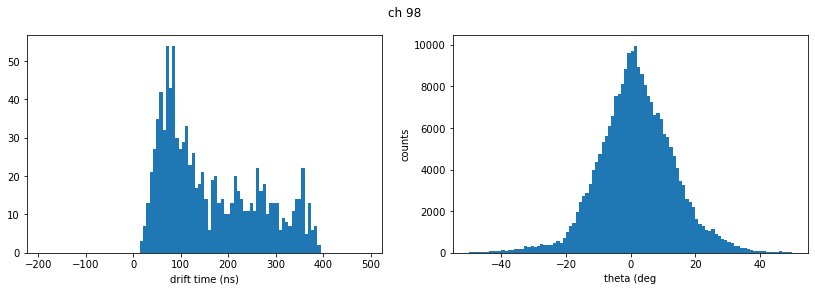

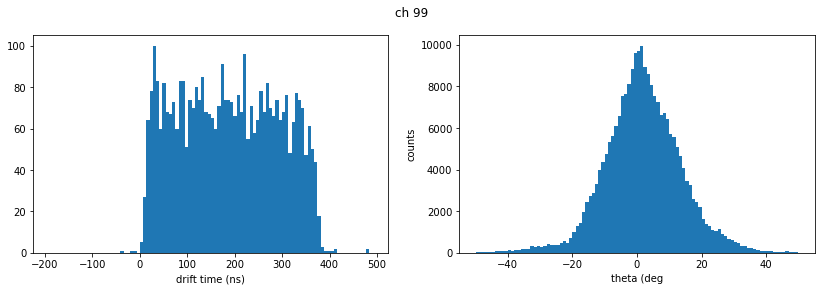

In [32]:
for key in f.keys():
    wire_df = pd.read_hdf('../data/test_ch.h5', key=key, mode="r")
    fig, ax = plt.subplots(ncols=2, figsize=(14,4))
    ax[0].hist(
        wire_df["HIT_DRIFT_TIME"],
        bins=100,
        range=(-190, 490)
    )
    ax[1].hist(
    full_df["THETA"],
    bins=100,
    range=(-50, 50)
    )
    fig.suptitle(f"ch {wire_df.iloc[0, 0]}")
    ax[0].set_xlabel("drift time (ns)")
    ax[1].set_xlabel("theta (deg")
    plt.ylabel("counts")
    plt.show()